In [1]:
import pandas as pd
import upsetplot as usp
import matplotlib as mp
from plotnine import (
    ggplot,
    aes,
    geom_bar,
    coord_flip,
    theme_set,
    theme_bw,
    scale_fill_manual
)

from mizani.formatters import percent_format

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

color_blind_friendly_palette = [
    "#E69F00",  # Orange
    "#56B4E9",  # Sky Blue
    "#009E73",  # Bluish Green
    "#F0E442",  # Yellow
    "#0072B2",  # Blue
    "#D55E00",  # Vermilion
    "#CC79A7",  # Reddish Purple
    "#999999",  # Grey
    "#882255",  # Wine
    "#88CCEE",  # Cyan
    "#AA4499",  # Purplish Pink
    "#332288",  # Indigo
]

theme_set(theme_bw())

SYMBOLS = {
    "SYMBOL_KIND_TYPE": "Type",
    "SYMBOL_KIND_CLASS": "Class",
    "SYMBOL_KIND_INTERFACE": "Interface",
    "SYMBOL_KIND_METHOD": "Method",
    "SYMBOL_KIND_CONSTRUCTOR": "Constructor",
    "SYMBOL_KIND_FIELD": "Field"
}

USES = {
    "SYMBOL_USE_TYPE_REFERENCE": "Reference",
    "SYMBOL_USE_VIRTUAL_INVOCATION": "VirtualInvocation",
    "SYMBOL_USE_OVERRIDING": "Overriding",
    "SYMBOL_USE_INVOCATION": "Invocation",
    "SYMBOL_USE_INHERITANCE": "Inheritance",
    "SYMBOL_USE_IMPLEMENTATION": "Implementation",
    "SYMBOL_USE_STATIC_INVOCATION": "StaticInvocation",
    "SYMBOL_USE_INSTANCE_FIELD_READ": "Read",
    "SYMBOL_USE_INSTANCE_FIELD_WRITE": "Write",
    "SYMBOL_USE_EXTENSION": "Extension",
    "SYMBOL_USE_INSTANTIATION": "Instantiation",
}

PROJECT_TYPES = {
    "CLIENT": "Client",
    "SAMPLE": "Sample",
    "TEST": "Test"
}

all_qualified_uses = [
    'Class > Inheritance',
    'Class > Instantiation',
    'Constructor > Invocation',
    'Field > Read',
    'Field > Write',
    'Interface > Extension',
    'Interface > Implementation',
    'Method > Invocation',
    'Method > Overriding',
    'Method > StaticInvocation',
    'Method > VirtualInvocation',
    'Type > Reference'
]

all_project_types = [
    "Sample",
    "Test",
    "Client"
]

all_apis = [
    "commons-cli",
    "jsoup",
    "spark"
]

In [2]:
def load_model(file, sep="|"):
    data = pd.read_csv(file, sep=sep)
    data['usageKind'].replace(SYMBOLS, inplace=True)
    data['usageType'].replace(USES, inplace=True)
    
    # bug fix for initial ucov versions not adding "Method > VirtualInvocation" when a "Method > Invocation" is found
    missing_data = data[data["usageKind"] == "Method"][data["usageType"] == "Invocation"]
    missing_data['usageType'].replace({"Invocation": "VirtualInvocation"}, inplace=True)
    data = pd.concat([data, missing_data], ignore_index=True)
    data.drop_duplicates(inplace=True)

    data.rename(columns={"projectType":"Type of project"}, inplace=True)
    data['Qualified use'] = data['usageKind'] + " > " + data['usageType']
    data['Type of project'].replace(PROJECT_TYPES, inplace=True)
    return data

In [3]:
def sanity_check_data(data_frame, filter_column, filter_column_value, value_of_interest):
    filtered_data = data_frame.loc[data_frame[filter_column] == filter_column_value]
    #display(filtered_data)

    total_percent_value = float(0)
    for percent_value in filtered_data[value_of_interest]:
        total_percent_value += float(percent_value)

    print("filtered by " + filter_column + "=" + filter_column_value + " with value of interest: " + value_of_interest + " sum: " + str(total_percent_value))

# all_qualified_uses_ever = pd.DataFrame(columns=["Qualified use"])
# global all_qualified_uses_ever

def fill_missing_data(input_data_frame, input_columns):
    # global all_qualified_uses_ever
    # column1values = input_data_frame[input_columns[0]].unique()
    column2values = input_data_frame[input_columns[1]].unique()

    column1values = all_qualified_uses

    empty = pd.DataFrame(columns=input_columns)

    for column1value in column1values:
        for column2value in column2values:
            empty = pd.concat(
                [
                    empty,
                    pd.DataFrame(columns=input_columns, data=[[column1value, column2value]])
                ],
                ignore_index=True
            )

    # all_qualified_uses_ever = pd.concat(
    #             [
    #                 all_qualified_uses_ever,
    #                 pd.DataFrame(columns=["Qualified use"], data=empty["Qualified use"])
    #             ],
    #             ignore_index=True
    #         )

    return pd.merge(empty, input_data_frame, on=input_columns, how="left").fillna(0)

### SUM

In [4]:
cc_sum = load_model("commons-cli-1.5.0.SUM.csv")
js_sum = load_model("JSoup-1.16.1.SUM.csv")
sp_sum = load_model("Spark-2.9.3.SUM.csv")

cc_sum["Library"] = "commons-cli"
js_sum["Library"] = "jsoup"
sp_sum["Library"] = "spark"

#all_sum = pd.concat([cc_sum, js_sum, sp_sum])

profile_cc = cc_sum[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_js = js_sum[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sp = sp_sum[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_sum = pd.concat([profile_cc, profile_js, profile_sp])
profiles_sum = fill_missing_data(profiles_sum, ["Qualified use", "Library"])
display(profiles_sum.head(15))

/tmp/ipykernel_4313/2955360465.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/tmp/ipykernel_4313/2955360465.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/tmp/ipykernel_4313/2955360465.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Qualified use,Library,Proportion
0,Class > Inheritance,commons-cli,0.023841
1,Class > Inheritance,jsoup,0.018021
2,Class > Inheritance,spark,0.030612
3,Class > Instantiation,commons-cli,0.023841
4,Class > Instantiation,jsoup,0.025502
5,Class > Instantiation,spark,0.019898
6,Constructor > Invocation,commons-cli,0.034437
7,Constructor > Invocation,jsoup,0.033322
8,Constructor > Invocation,spark,0.034694
9,Field > Read,commons-cli,0.047682


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: sum-uses-per-library.pdf


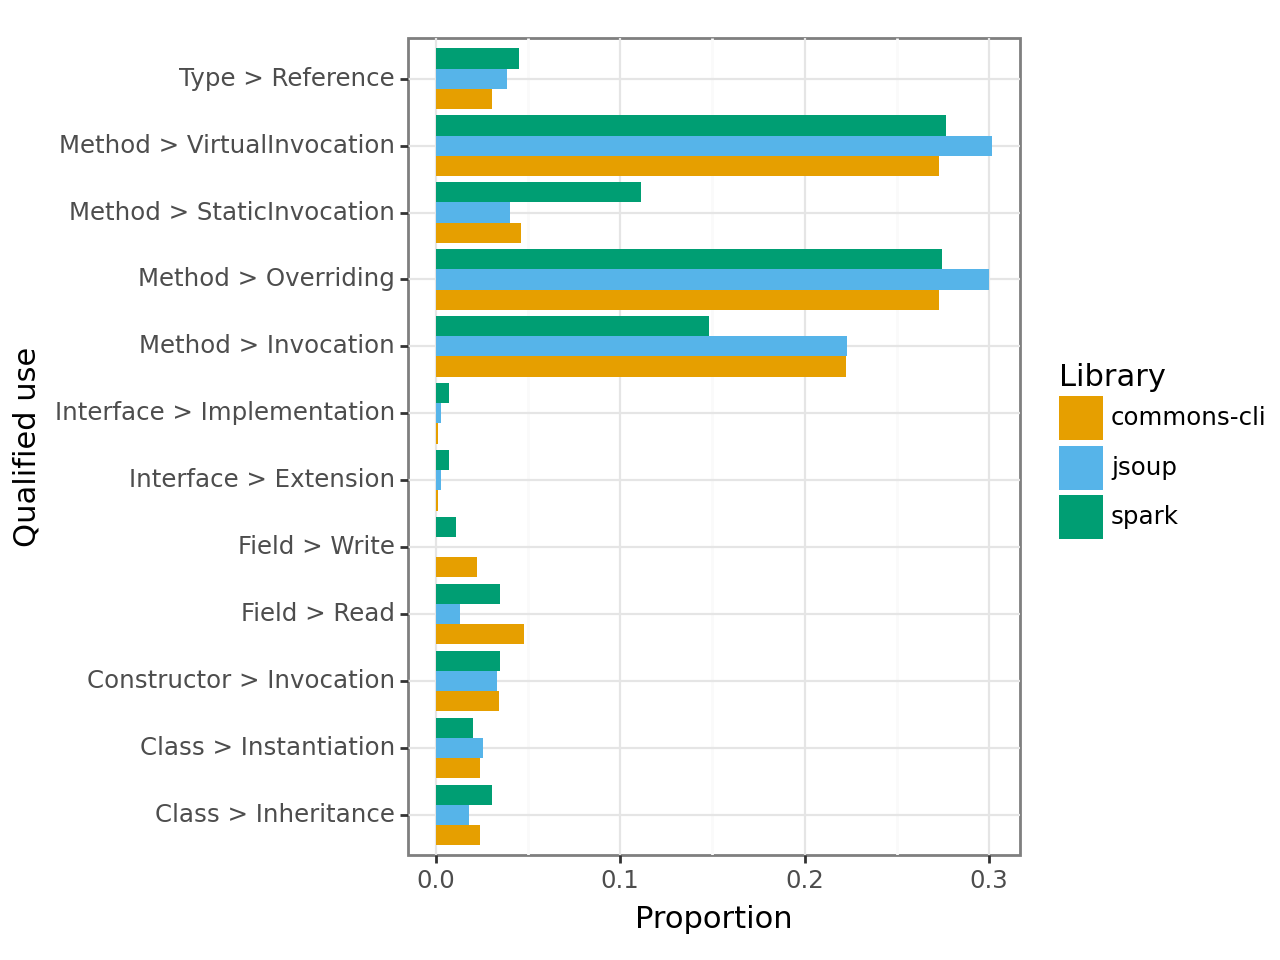

<Figure Size: (640 x 480)>

In [5]:
p = ggplot(profiles_sum, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Library"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("sum-uses-per-library.pdf")
p

filtered by Library=commons-cli with value of interest: Proportion sum: 1.0
filtered by Library=spark with value of interest: Proportion sum: 0.9999999999999999
filtered by Library=jsoup with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: sum-library-profiles.pdf


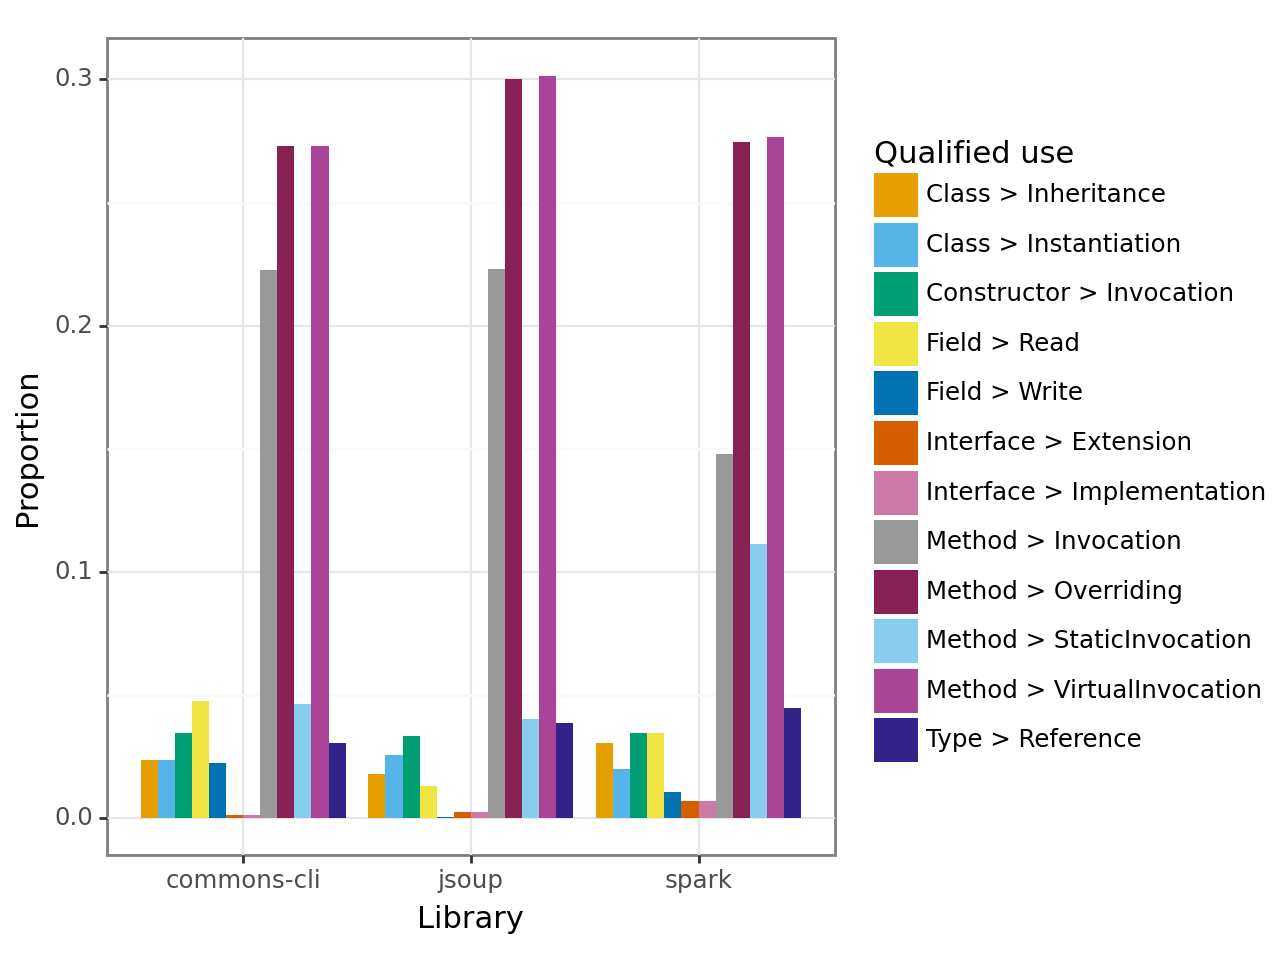

<Figure Size: (640 x 480)>

In [6]:
p = ggplot(profiles_sum, aes(x="Library")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_sum, filter_column="Library", filter_column_value="commons-cli", value_of_interest="Proportion")
sanity_check_data(profiles_sum, filter_column="Library", filter_column_value="spark", value_of_interest="Proportion")
sanity_check_data(profiles_sum, filter_column="Library", filter_column_value="jsoup", value_of_interest="Proportion")
p.save("sum-library-profiles.pdf")
p

### SUF

In [7]:
cc_suf = load_model("commons-cli-1.5.0.SUF.csv")
js_suf = load_model("JSoup-1.16.1.SUF.csv")
sp_suf = load_model("Spark-2.9.3.SUF.csv")

cc_suf["Library"] = "commons-cli"
js_suf["Library"] = "jsoup"
sp_suf["Library"] = "spark"

#all_suf = pd.concat([cc_suf, js_suf, sp_suf])

profile_cc_suf = cc_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_js_suf = js_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sp_suf = sp_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_suf = pd.concat([profile_cc_suf, profile_js_suf, profile_sp_suf])
profiles_suf = fill_missing_data(profiles_suf, ["Qualified use", "Library"])
display(profiles_suf.head(15))

/tmp/ipykernel_4313/2955360465.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/tmp/ipykernel_4313/2955360465.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/tmp/ipykernel_4313/2955360465.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Qualified use,Library,Proportion
0,Class > Inheritance,commons-cli,0.000050
1,Class > Inheritance,jsoup,0.000100
2,Class > Inheritance,spark,0.000837
3,Class > Instantiation,commons-cli,0.077140
4,Class > Instantiation,jsoup,0.009907
5,Class > Instantiation,spark,0.011976
6,Constructor > Invocation,commons-cli,0.077140
7,Constructor > Invocation,jsoup,0.009907
8,Constructor > Invocation,spark,0.011976
9,Field > Read,commons-cli,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: suf-uses-per-library.pdf


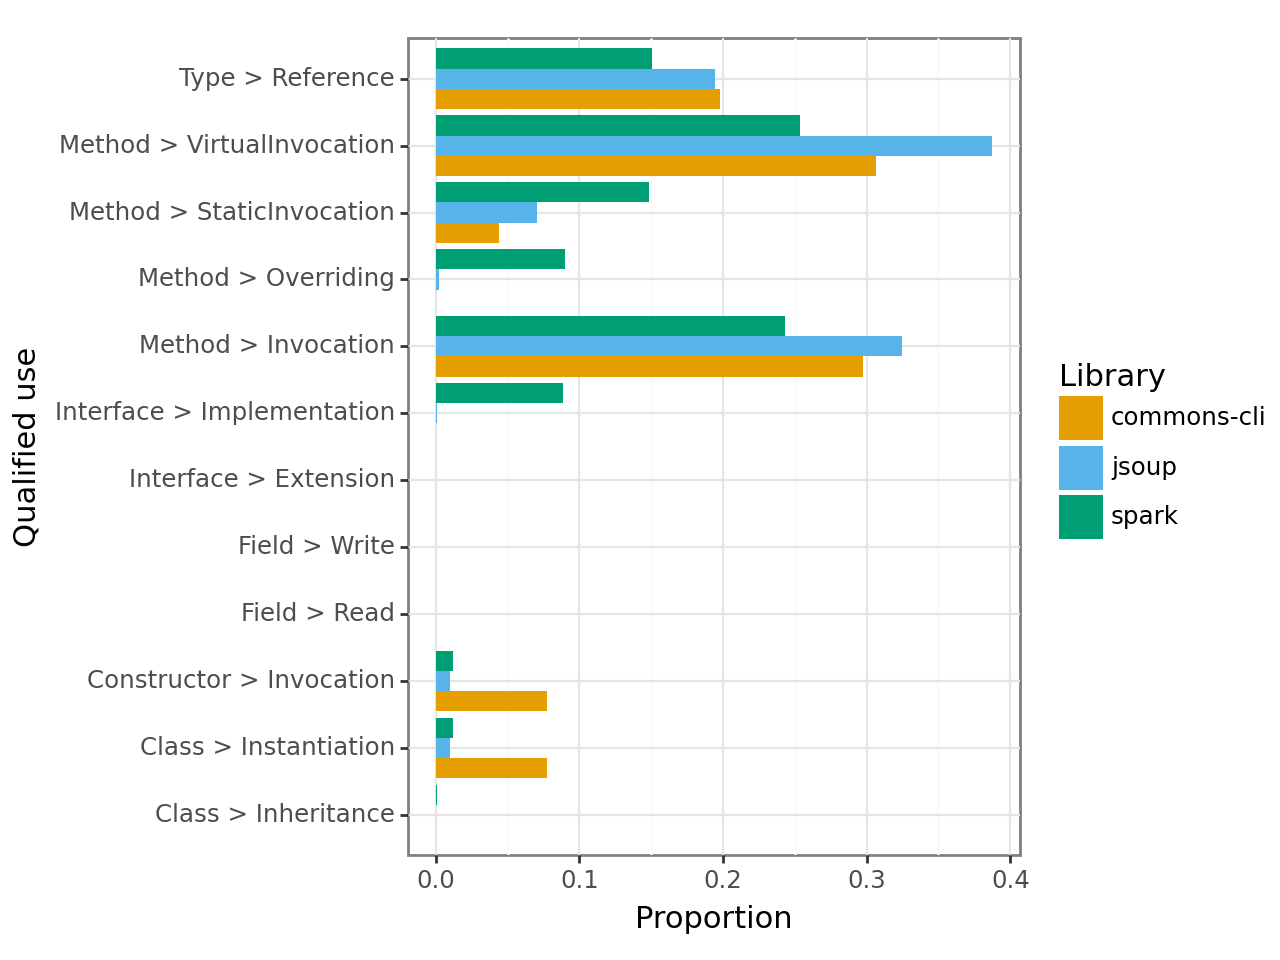

<Figure Size: (640 x 480)>

In [8]:
p = ggplot(profiles_suf, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Library"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("suf-uses-per-library.pdf")
p

filtered by Library=commons-cli with value of interest: Proportion sum: 1.0
filtered by Library=spark with value of interest: Proportion sum: 1.0
filtered by Library=jsoup with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: suf-library-profiles.pdf


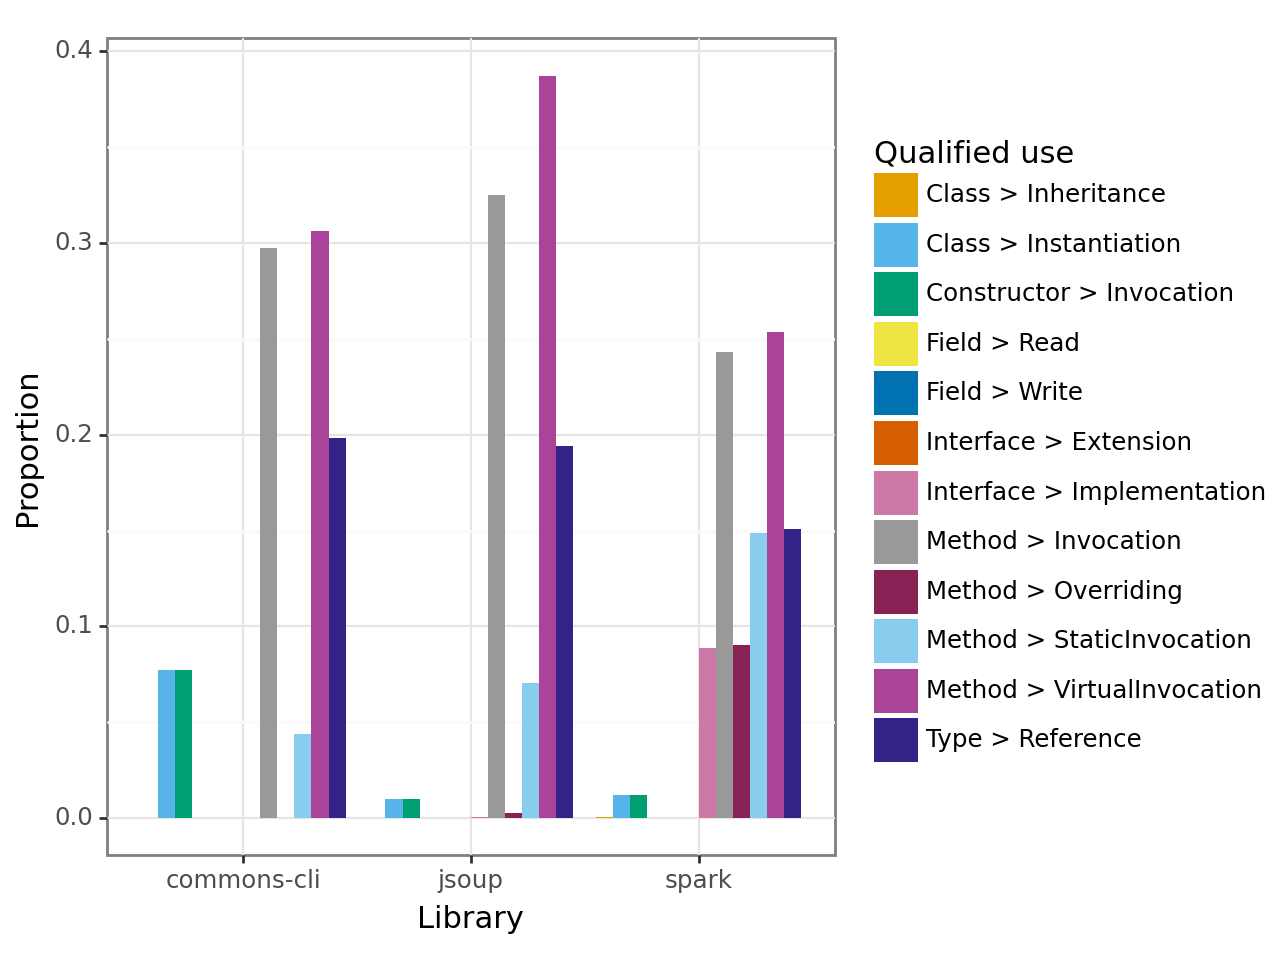

<Figure Size: (640 x 480)>

In [9]:
p = ggplot(profiles_suf, aes(x="Library")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_suf, filter_column="Library", filter_column_value="commons-cli", value_of_interest="Proportion")
sanity_check_data(profiles_suf, filter_column="Library", filter_column_value="spark", value_of_interest="Proportion")
sanity_check_data(profiles_suf, filter_column="Library", filter_column_value="jsoup", value_of_interest="Proportion")
p.save("suf-library-profiles.pdf")
p

### Test SUF

In [10]:
test_cc_suf = cc_suf[cc_suf["Type of project"] == "Test"]
test_js_suf = js_suf[js_suf["Type of project"] == "Test"]
test_sp_suf = sp_suf[sp_suf["Type of project"] == "Test"]

profile_cc_test_suf = test_cc_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_js_test_suf = test_js_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sp_test_suf = test_sp_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_test_suf = pd.concat([profile_cc_test_suf, profile_js_test_suf, profile_sp_test_suf])
profiles_test_suf = fill_missing_data(profiles_test_suf, ["Qualified use", "Library"])
display(profiles_test_suf.head(15))

,Qualified use,Library,Proportion
0,Class > Inheritance,commons-cli,0.000426
1,Class > Inheritance,jsoup,0.000069
2,Class > Inheritance,spark,0.003115
3,Class > Instantiation,commons-cli,0.065245
4,Class > Instantiation,jsoup,0.015230
5,Class > Instantiation,spark,0.014330
6,Constructor > Invocation,commons-cli,0.065245
7,Constructor > Invocation,jsoup,0.015230
8,Constructor > Invocation,spark,0.014330
9,Field > Read,commons-cli,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: test-suf-uses-per-library.pdf


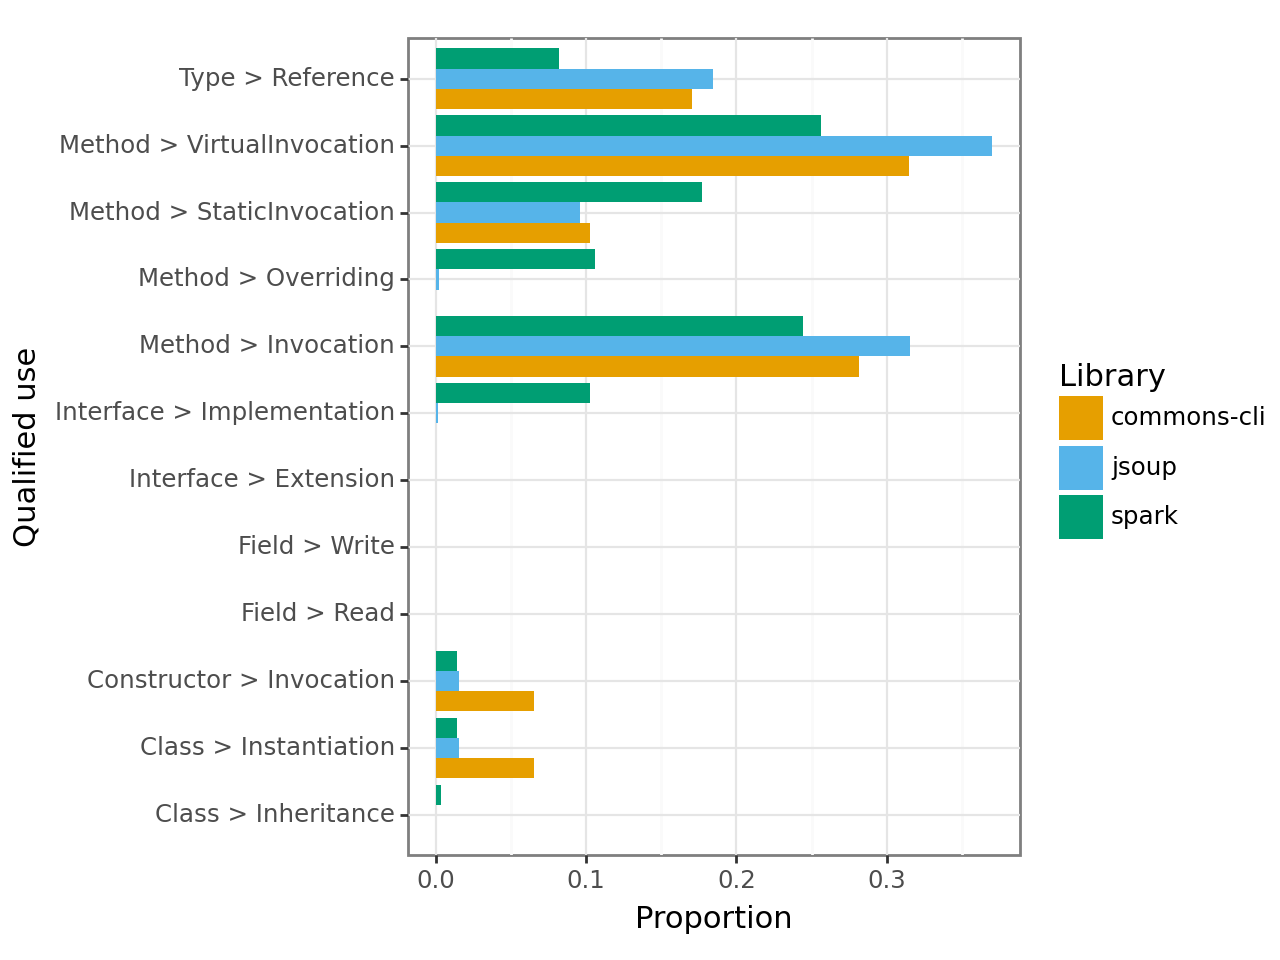

<Figure Size: (640 x 480)>

In [11]:
p = ggplot(profiles_test_suf, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Library"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("test-suf-uses-per-library.pdf")
p

filtered by Library=commons-cli with value of interest: Proportion sum: 0.9999999999999999
filtered by Library=spark with value of interest: Proportion sum: 1.0000000000000002
filtered by Library=jsoup with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: test-suf-library-profiles.pdf


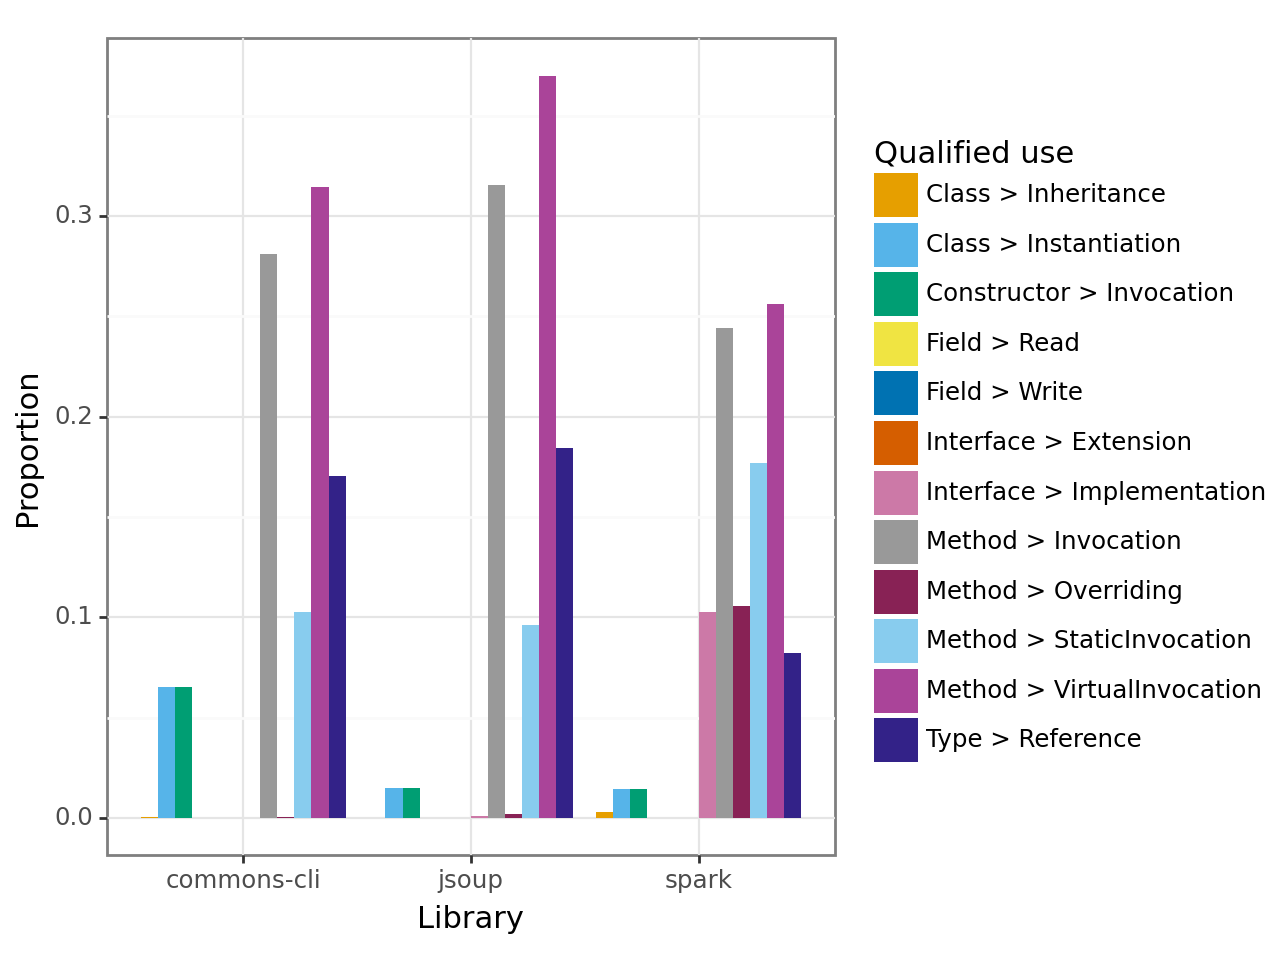

<Figure Size: (640 x 480)>

In [12]:
p = ggplot(profiles_test_suf, aes(x="Library")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_test_suf, filter_column="Library", filter_column_value="commons-cli", value_of_interest="Proportion")
sanity_check_data(profiles_test_suf, filter_column="Library", filter_column_value="spark", value_of_interest="Proportion")
sanity_check_data(profiles_test_suf, filter_column="Library", filter_column_value="jsoup", value_of_interest="Proportion")
p.save("test-suf-library-profiles.pdf")
p

### Sample SUF

In [13]:
sample_cc_suf = cc_suf[cc_suf["Type of project"] == "Sample"]
sample_js_suf = js_suf[js_suf["Type of project"] == "Sample"]
sample_sp_suf = sp_suf[sp_suf["Type of project"] == "Sample"]

profile_cc_sample_suf = sample_cc_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_js_sample_suf = sample_js_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sp_sample_suf = sample_sp_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_sample_suf = pd.concat([profile_cc_sample_suf, profile_js_sample_suf, profile_sp_sample_suf])
profiles_sample_suf = fill_missing_data(profiles_sample_suf, ["Qualified use", "Library"])
display(profiles_sample_suf.head(15))

,Qualified use,Library,Proportion
0,Class > Inheritance,commons-cli,0.000000
1,Class > Inheritance,jsoup,0.000000
2,Class > Inheritance,spark,0.009655
3,Class > Instantiation,commons-cli,0.127660
4,Class > Instantiation,jsoup,0.000000
5,Class > Instantiation,spark,0.034483
6,Constructor > Invocation,commons-cli,0.127660
7,Constructor > Invocation,jsoup,0.000000
8,Constructor > Invocation,spark,0.034483
9,Field > Read,commons-cli,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: sample-suf-uses-per-library.pdf


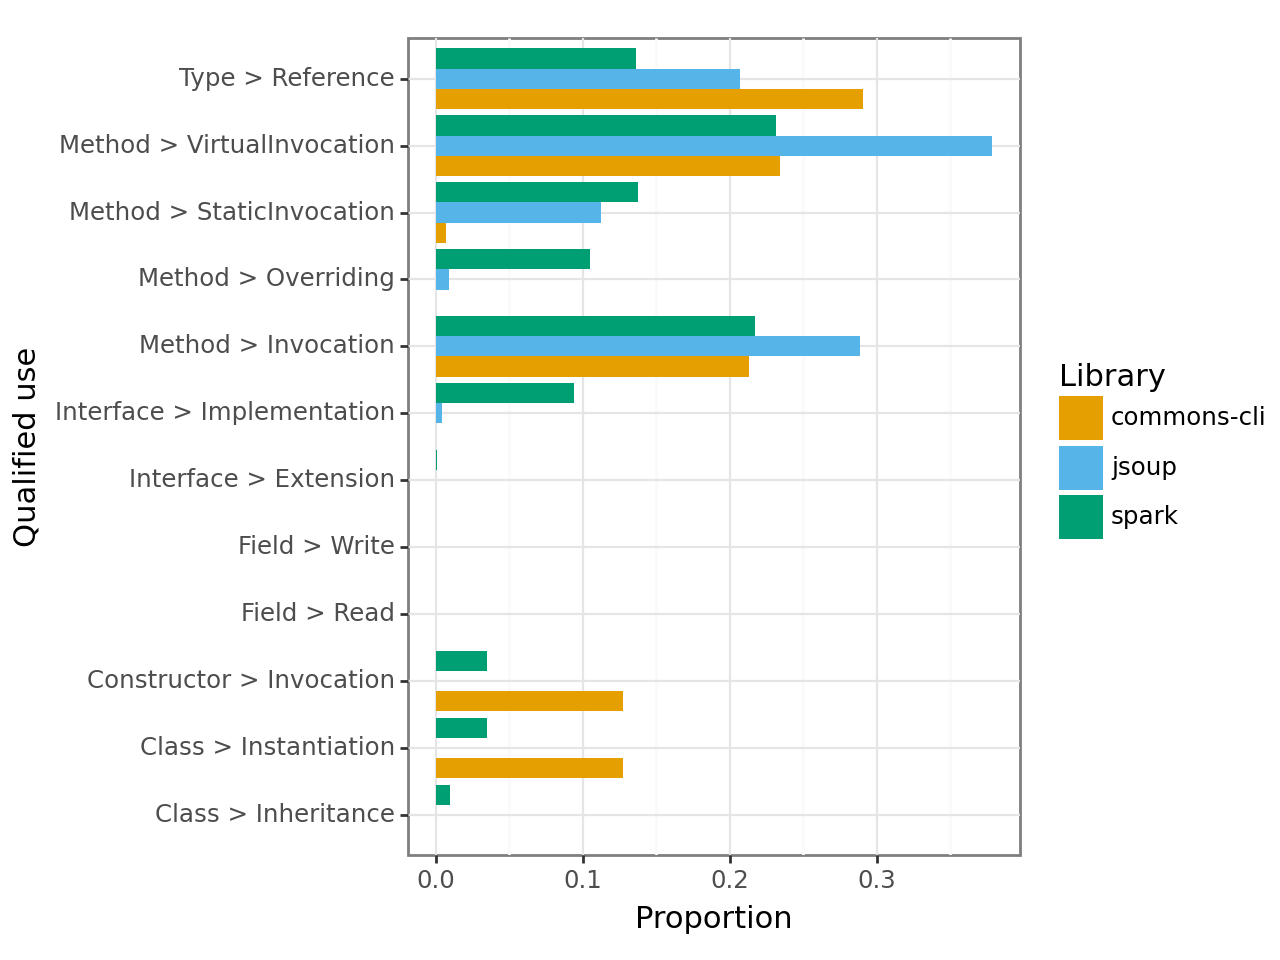

<Figure Size: (640 x 480)>

In [14]:
p = ggplot(profiles_sample_suf, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Library"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("sample-suf-uses-per-library.pdf")
p

filtered by Library=commons-cli with value of interest: Proportion sum: 1.0
filtered by Library=spark with value of interest: Proportion sum: 1.0
filtered by Library=jsoup with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: sample-suf-library-profiles.pdf


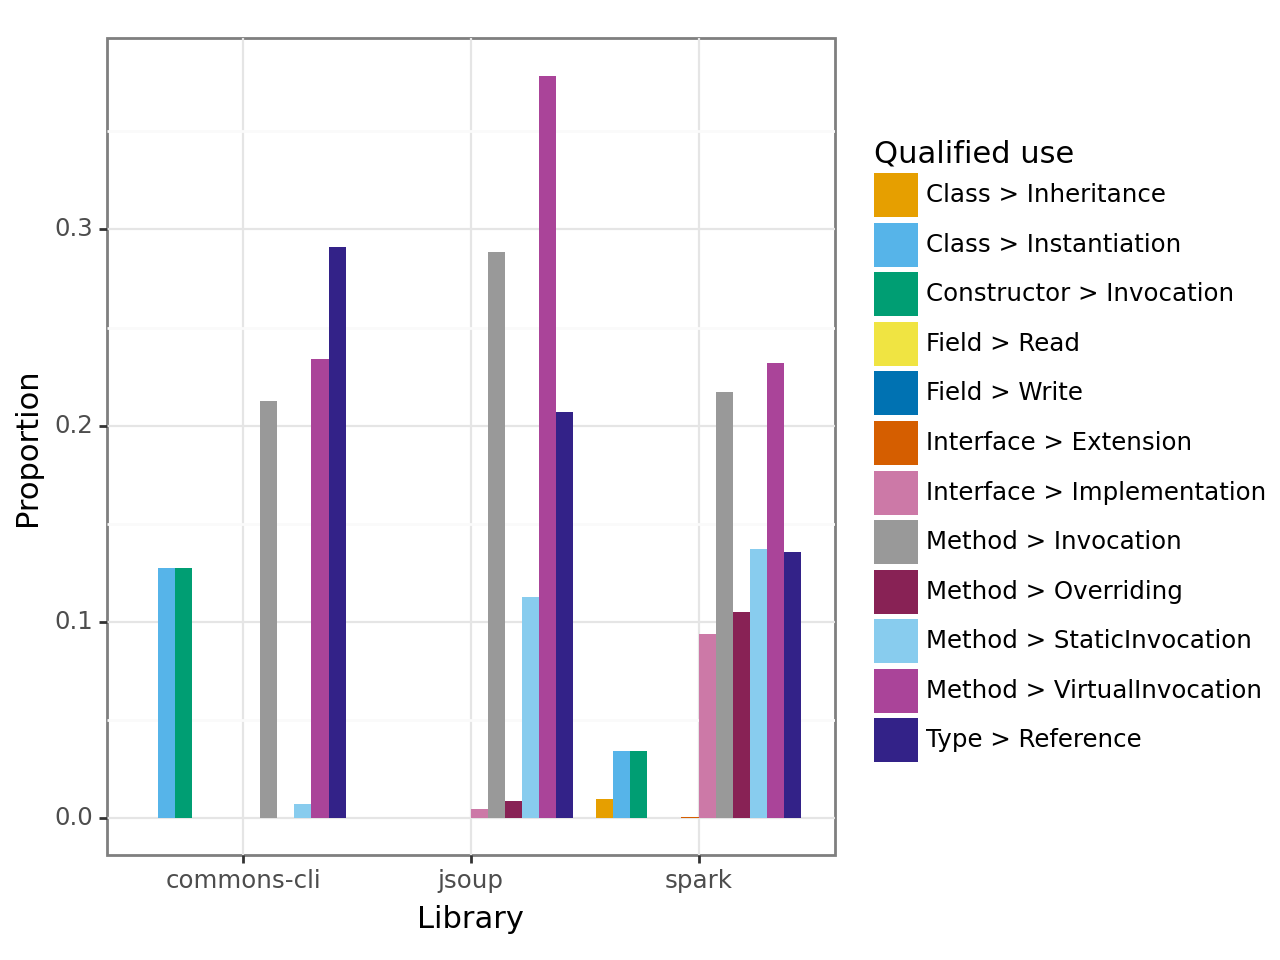

<Figure Size: (640 x 480)>

In [15]:
p = ggplot(profiles_sample_suf, aes(x="Library")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_sample_suf, filter_column="Library", filter_column_value="commons-cli", value_of_interest="Proportion")
sanity_check_data(profiles_sample_suf, filter_column="Library", filter_column_value="spark", value_of_interest="Proportion")
sanity_check_data(profiles_sample_suf, filter_column="Library", filter_column_value="jsoup", value_of_interest="Proportion")
p.save("sample-suf-library-profiles.pdf")
p

### Client SUF

In [16]:
client_cc_suf = cc_suf[cc_suf["Type of project"] == "Client"]
client_js_suf = js_suf[js_suf["Type of project"] == "Client"]
client_sp_suf = sp_suf[sp_suf["Type of project"] == "Client"]

profile_cc_client_suf = client_cc_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_js_client_suf = client_js_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sp_client_suf = client_sp_suf[["Qualified use", "Library", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Library"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_client_suf = pd.concat([profile_cc_client_suf, profile_js_client_suf, profile_sp_client_suf])
profiles_client_suf = fill_missing_data(profiles_client_suf, ["Qualified use", "Library"])
display(profiles_client_suf.head(15))

,Qualified use,Library,Proportion
0,Class > Inheritance,commons-cli,0.000027
1,Class > Inheritance,jsoup,0.000131
2,Class > Inheritance,spark,0.000048
3,Class > Instantiation,commons-cli,0.077794
4,Class > Instantiation,jsoup,0.004985
5,Class > Instantiation,spark,0.010227
6,Constructor > Invocation,commons-cli,0.077794
7,Constructor > Invocation,jsoup,0.004985
8,Constructor > Invocation,spark,0.010227
9,Field > Read,commons-cli,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: client-suf-uses-per-library.pdf


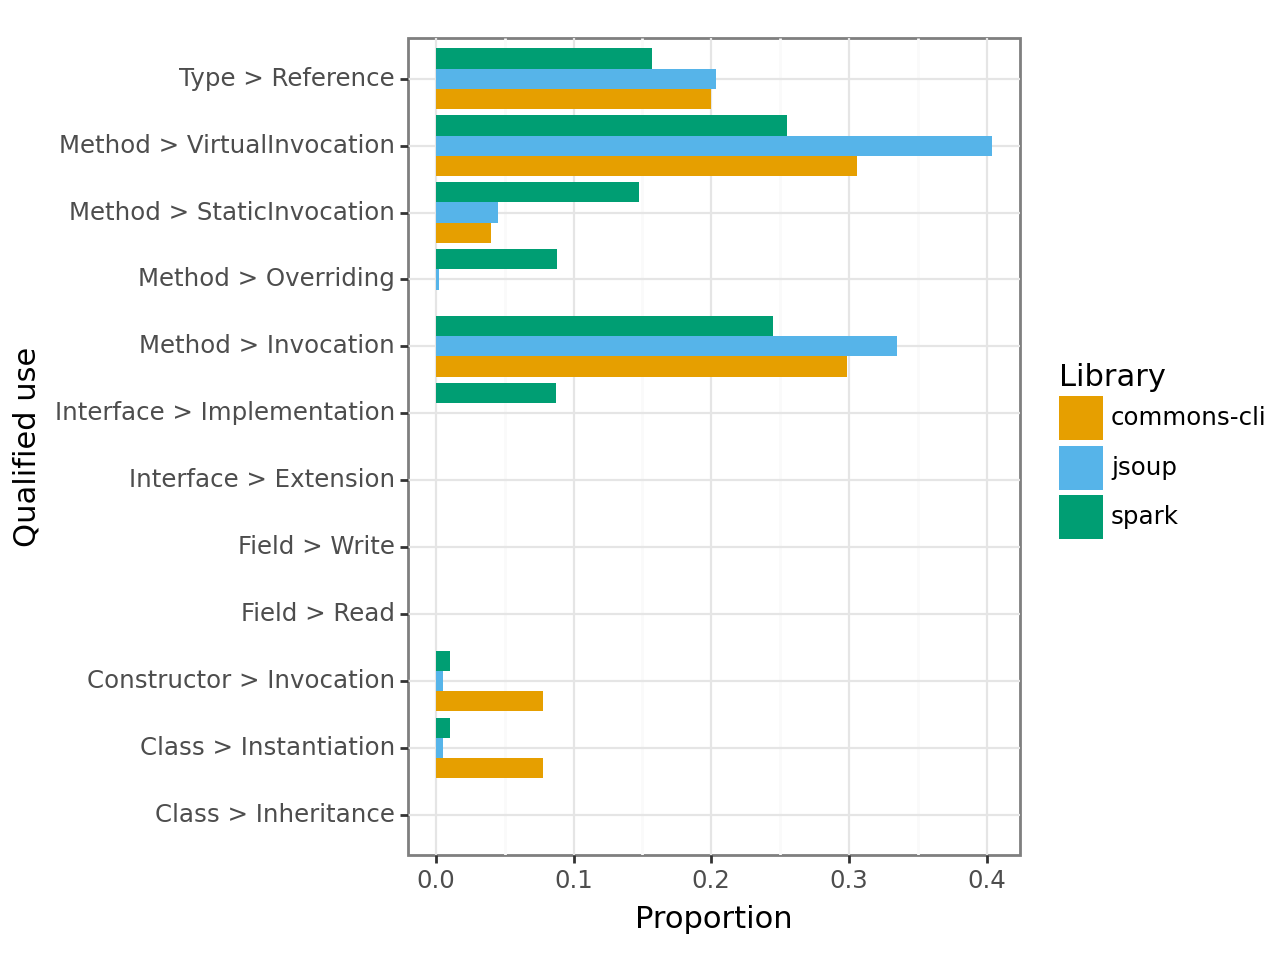

<Figure Size: (640 x 480)>

In [17]:
p = ggplot(profiles_client_suf, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Library"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("client-suf-uses-per-library.pdf")
p

filtered by Library=commons-cli with value of interest: Proportion sum: 1.0
filtered by Library=spark with value of interest: Proportion sum: 1.0
filtered by Library=jsoup with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: client-suf-library-profiles.pdf


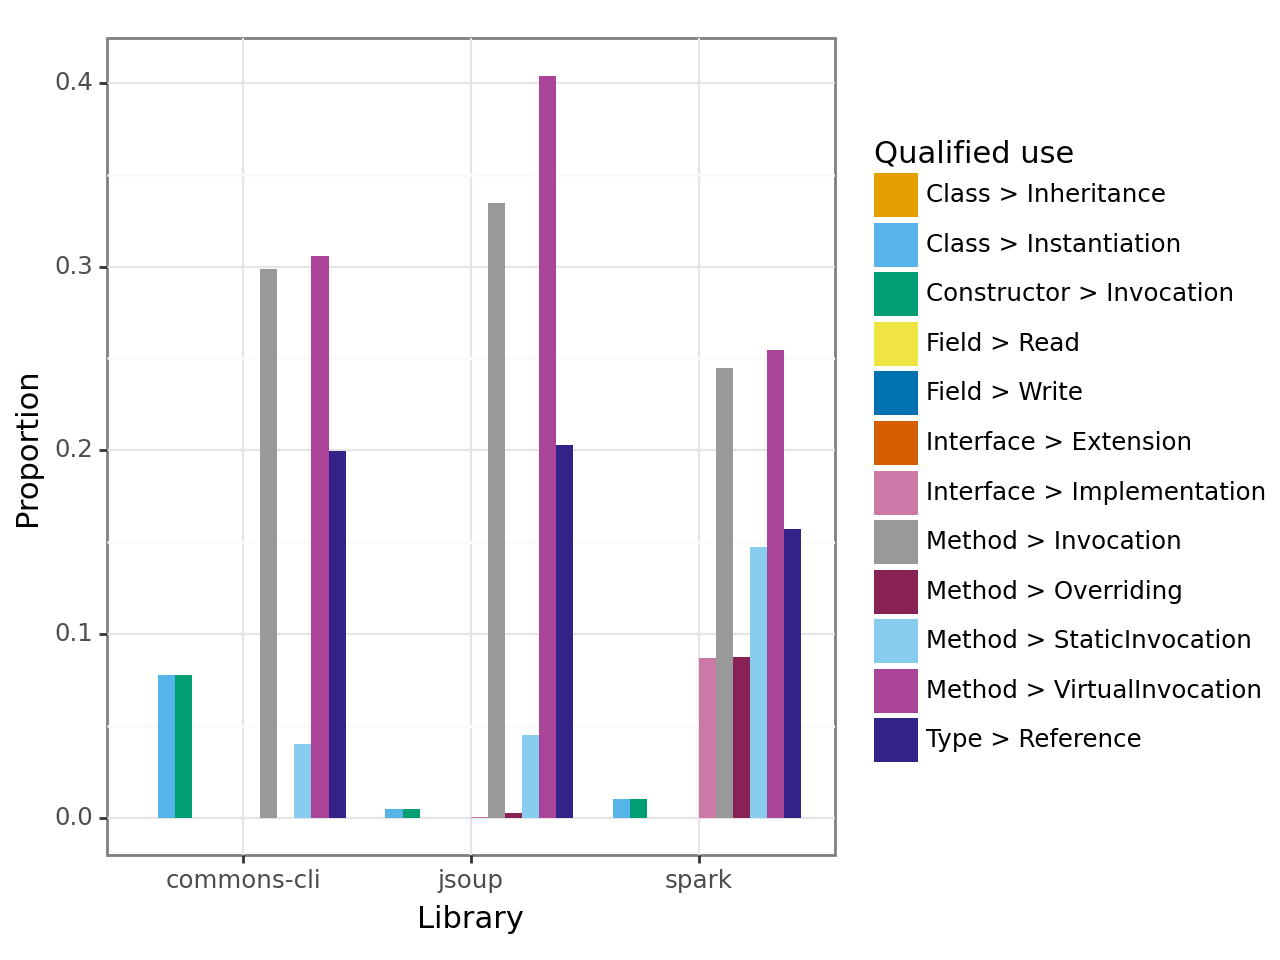

<Figure Size: (640 x 480)>

In [18]:
p = ggplot(profiles_client_suf, aes(x="Library")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_client_suf, filter_column="Library", filter_column_value="commons-cli", value_of_interest="Proportion")
sanity_check_data(profiles_client_suf, filter_column="Library", filter_column_value="spark", value_of_interest="Proportion")
sanity_check_data(profiles_client_suf, filter_column="Library", filter_column_value="jsoup", value_of_interest="Proportion")
p.save("client-suf-library-profiles.pdf")
p

### SUF profile by type for Commons Cli

In [19]:
profile_test_cc_suf = test_cc_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sample_cc_suf = sample_cc_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_client_cc_suf = client_cc_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_cc_suf_by_type = pd.concat([profile_test_cc_suf, profile_sample_cc_suf, profile_client_cc_suf])
profiles_cc_suf_by_type = fill_missing_data(profiles_cc_suf_by_type, ["Qualified use", "Type of project"])
display(profiles_cc_suf_by_type.head(15))

,Qualified use,Type of project,Proportion
0,Class > Inheritance,Test,0.000426
1,Class > Inheritance,Sample,0.000000
2,Class > Inheritance,Client,0.000027
3,Class > Instantiation,Test,0.065245
4,Class > Instantiation,Sample,0.127660
5,Class > Instantiation,Client,0.077794
6,Constructor > Invocation,Test,0.065245
7,Constructor > Invocation,Sample,0.127660
8,Constructor > Invocation,Client,0.077794
9,Field > Read,Test,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: commons-cli-suf-uses-per-type.pdf


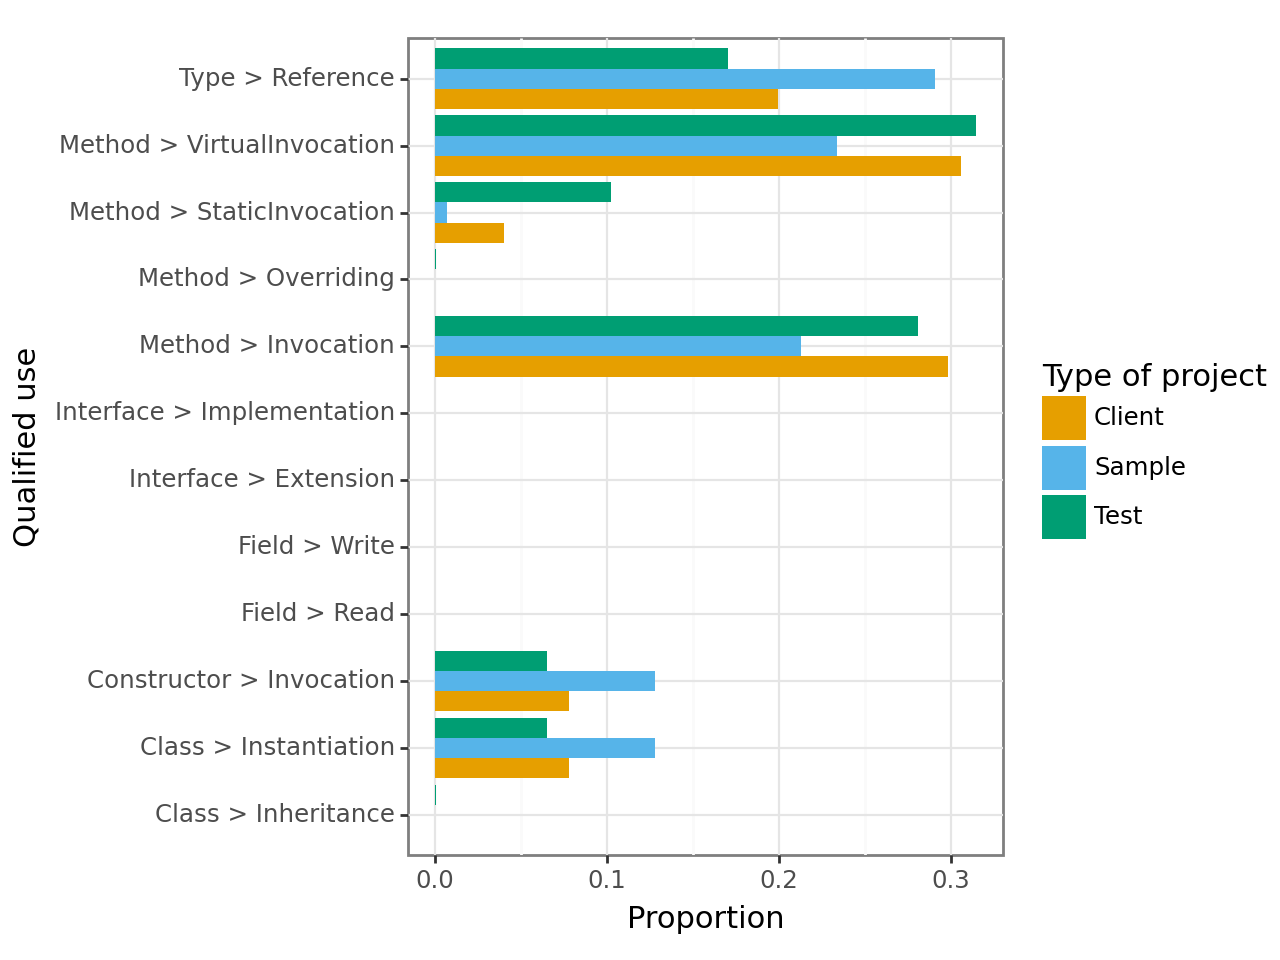

<Figure Size: (640 x 480)>

In [20]:
p = ggplot(profiles_cc_suf_by_type, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Type of project"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("commons-cli-suf-uses-per-type.pdf")
p

filtered by Type of project=Test with value of interest: Proportion sum: 0.9999999999999999
filtered by Type of project=Sample with value of interest: Proportion sum: 1.0
filtered by Type of project=Client with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: commons-cli-suf-type-profiles.pdf


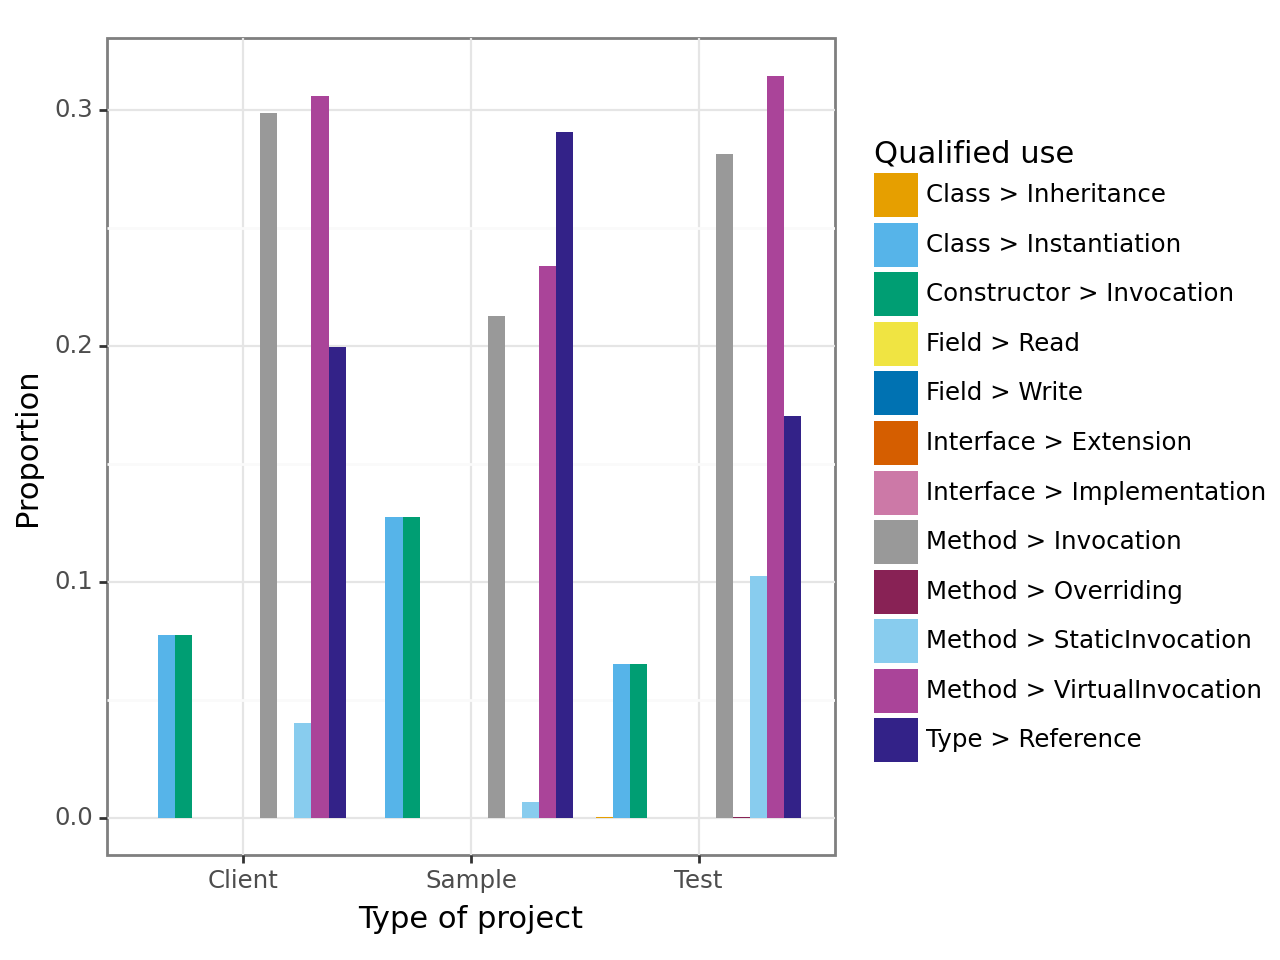

<Figure Size: (640 x 480)>

In [21]:
p = ggplot(profiles_cc_suf_by_type, aes(x="Type of project")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_cc_suf_by_type, filter_column="Type of project", filter_column_value="Test", value_of_interest="Proportion")
sanity_check_data(profiles_cc_suf_by_type, filter_column="Type of project", filter_column_value="Sample", value_of_interest="Proportion")
sanity_check_data(profiles_cc_suf_by_type, filter_column="Type of project", filter_column_value="Client", value_of_interest="Proportion")
p.save("commons-cli-suf-type-profiles.pdf")
p

### SUF profile by type for JSoup

In [22]:
profile_test_js_suf = test_js_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sample_js_suf = sample_js_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_client_js_suf = client_js_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_js_suf_by_type = pd.concat([profile_test_js_suf, profile_sample_js_suf, profile_client_js_suf])
profiles_js_suf_by_type = fill_missing_data(profiles_js_suf_by_type, ["Qualified use", "Type of project"])
display(profiles_js_suf_by_type.head(15))

,Qualified use,Type of project,Proportion
0,Class > Inheritance,Test,0.000069
1,Class > Inheritance,Sample,0.000000
2,Class > Inheritance,Client,0.000131
3,Class > Instantiation,Test,0.015230
4,Class > Instantiation,Sample,0.000000
5,Class > Instantiation,Client,0.004985
6,Constructor > Invocation,Test,0.015230
7,Constructor > Invocation,Sample,0.000000
8,Constructor > Invocation,Client,0.004985
9,Field > Read,Test,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: jsoup-suf-uses-per-type.pdf


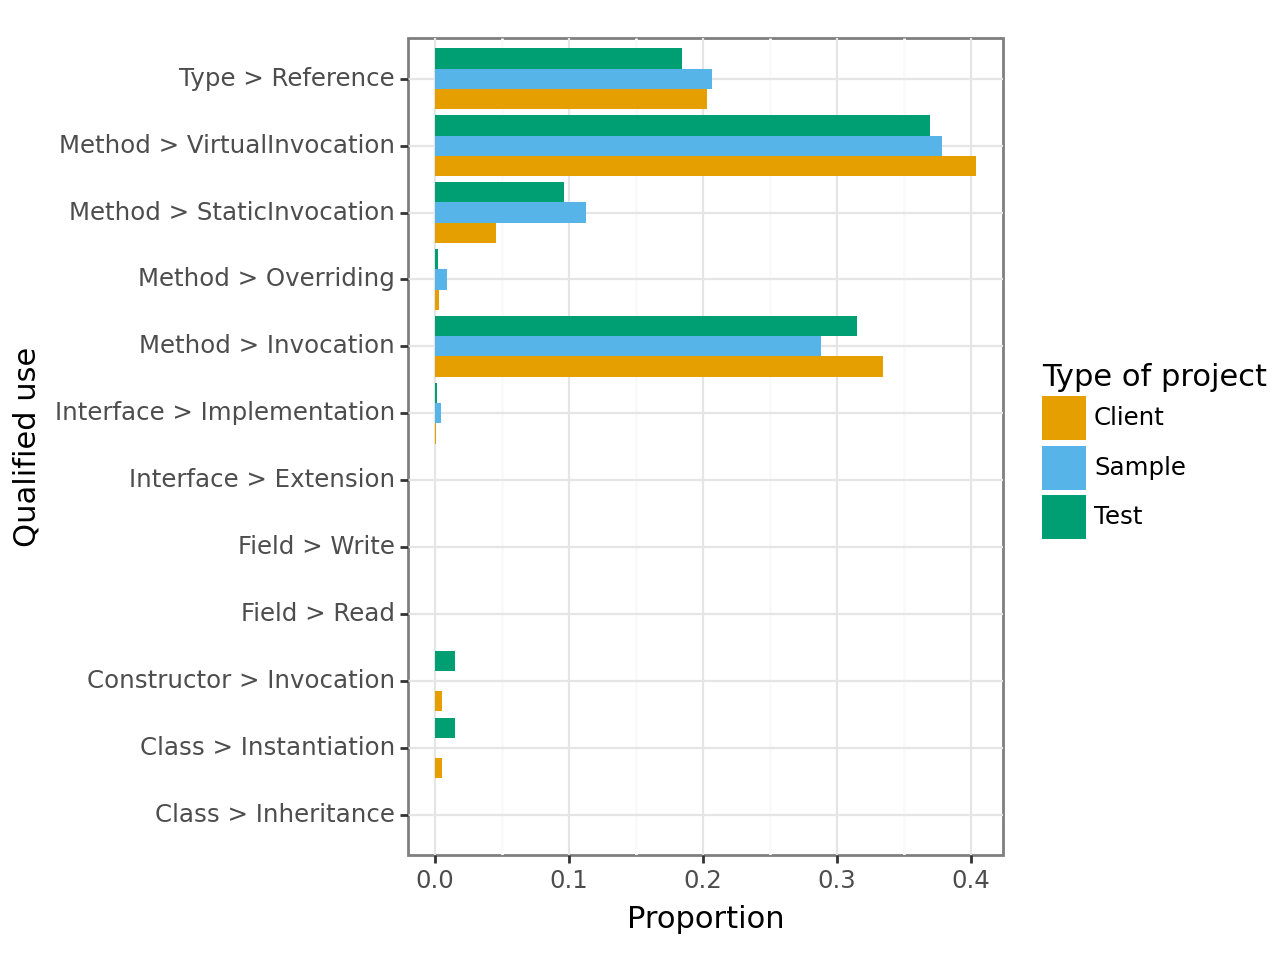

<Figure Size: (640 x 480)>

In [23]:
p = ggplot(profiles_js_suf_by_type, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Type of project"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("jsoup-suf-uses-per-type.pdf")
p

filtered by Type of project=Test with value of interest: Proportion sum: 1.0
filtered by Type of project=Sample with value of interest: Proportion sum: 1.0
filtered by Type of project=Client with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: jsoup-suf-type-profiles.pdf


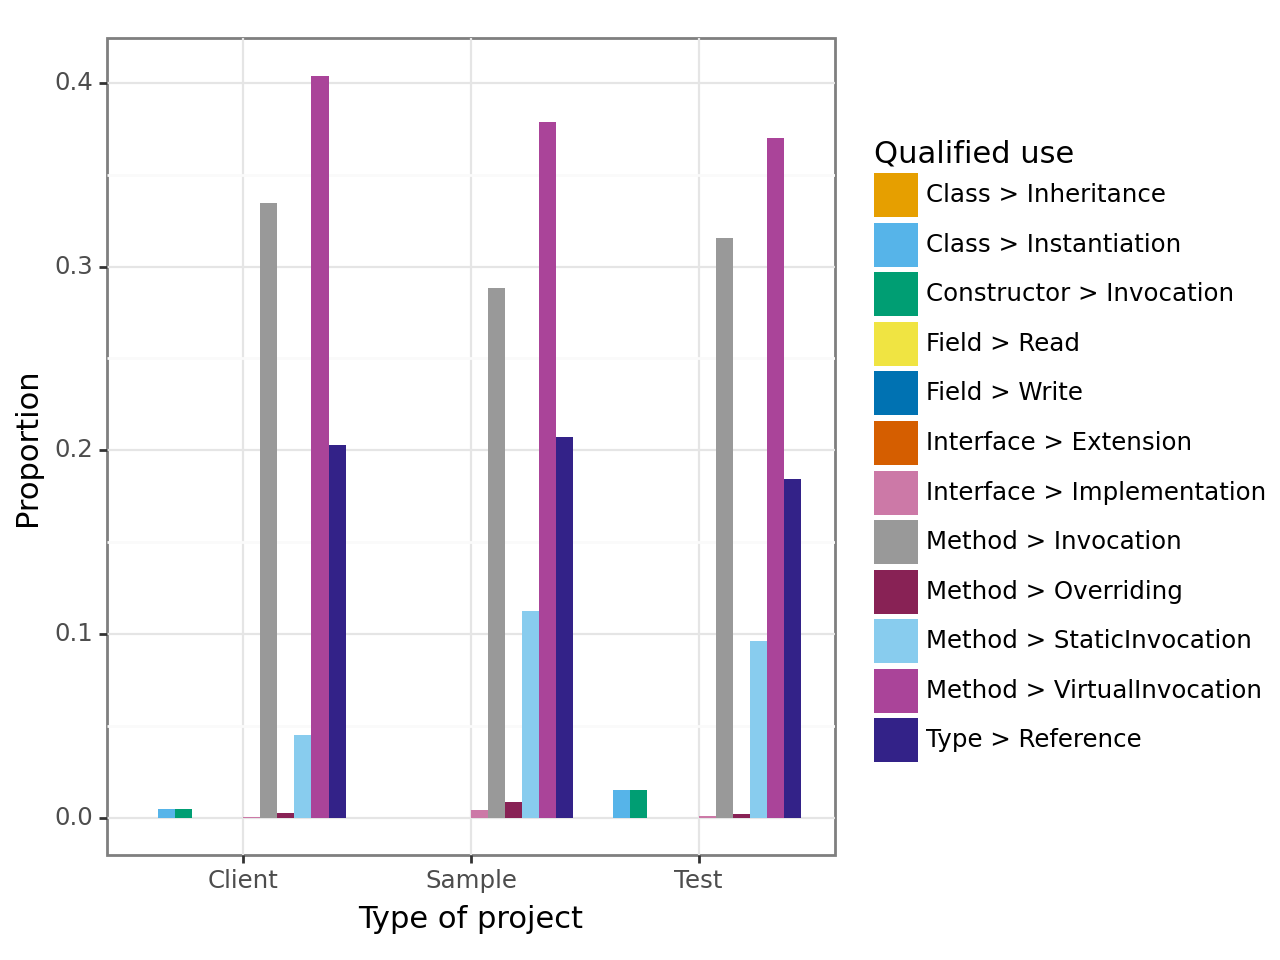

<Figure Size: (640 x 480)>

In [24]:
p = ggplot(profiles_js_suf_by_type, aes(x="Type of project")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_js_suf_by_type, filter_column="Type of project", filter_column_value="Test", value_of_interest="Proportion")
sanity_check_data(profiles_js_suf_by_type, filter_column="Type of project", filter_column_value="Sample", value_of_interest="Proportion")
sanity_check_data(profiles_js_suf_by_type, filter_column="Type of project", filter_column_value="Client", value_of_interest="Proportion")
p.save("jsoup-suf-type-profiles.pdf")
p

### SUF profile by type for Spark

In [25]:
profile_test_sp_suf = test_sp_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_sample_sp_suf = sample_sp_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()
profile_client_sp_suf = client_sp_suf[["Qualified use", "Type of project", "projectId"]].rename(columns={"projectId":"Proportion"}).groupby(["Qualified use", "Type of project"]).count().apply(lambda x : x / float(x.sum())).reset_index()

profiles_sp_suf_by_type = pd.concat([profile_test_sp_suf, profile_sample_sp_suf, profile_client_sp_suf])
profiles_sp_suf_by_type = fill_missing_data(profiles_sp_suf_by_type, ["Qualified use", "Type of project"])
display(profiles_sp_suf_by_type.head(15))

,Qualified use,Type of project,Proportion
0,Class > Inheritance,Test,0.003115
1,Class > Inheritance,Sample,0.009655
2,Class > Inheritance,Client,0.000048
3,Class > Instantiation,Test,0.014330
4,Class > Instantiation,Sample,0.034483
5,Class > Instantiation,Client,0.010227
6,Constructor > Invocation,Test,0.014330
7,Constructor > Invocation,Sample,0.034483
8,Constructor > Invocation,Client,0.010227
9,Field > Read,Test,0.000000


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: spark-suf-uses-per-type.pdf


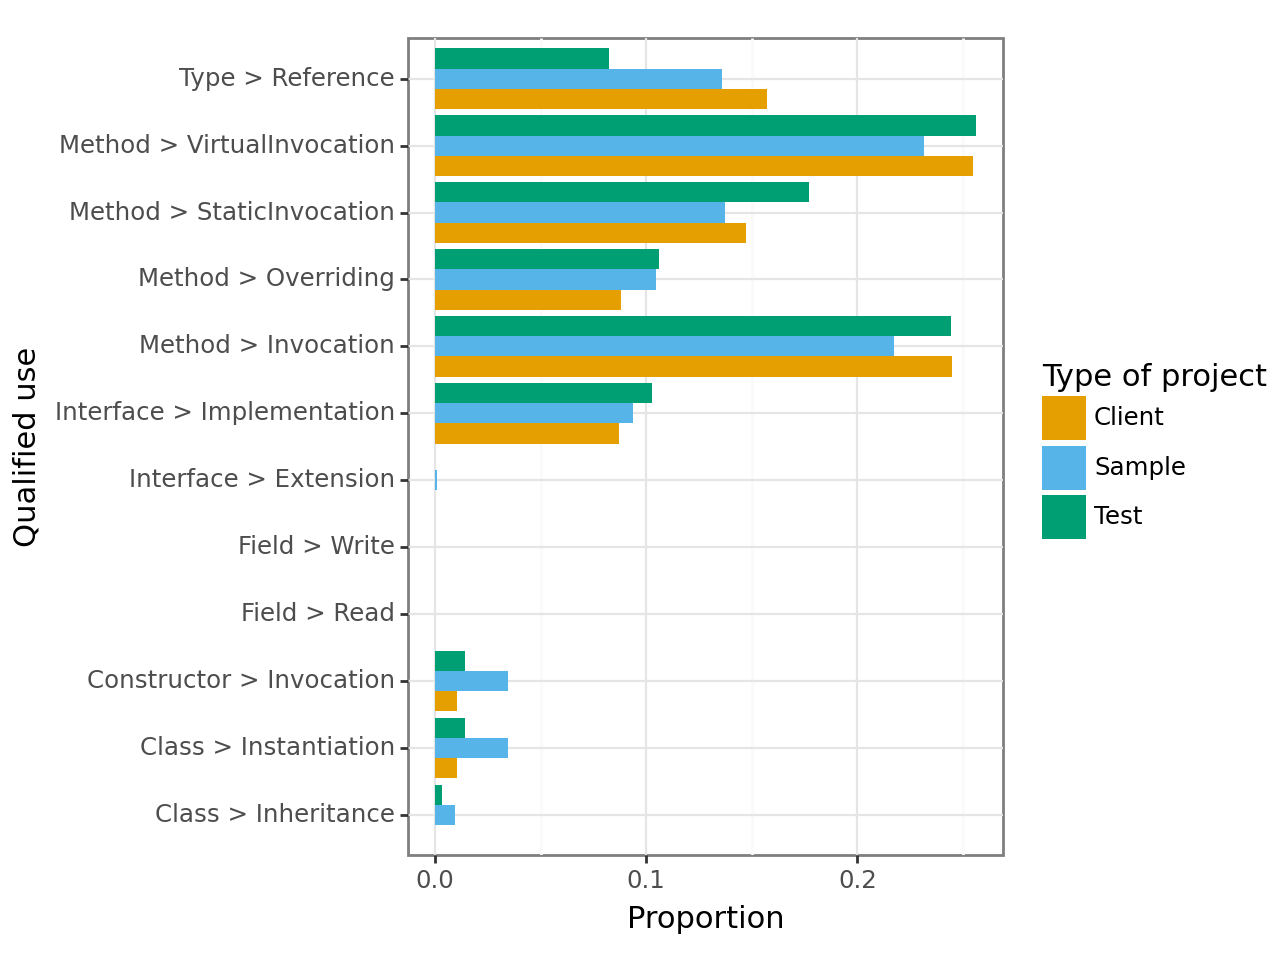

<Figure Size: (640 x 480)>

In [26]:
p = ggplot(profiles_sp_suf_by_type, aes(x="Qualified use")) + geom_bar(aes(y="Proportion", fill="Type of project"), stat="identity", position="dodge") + coord_flip() + scale_fill_manual(values=color_blind_friendly_palette)
p.save("spark-suf-uses-per-type.pdf")
p

filtered by Type of project=Test with value of interest: Proportion sum: 1.0000000000000002
filtered by Type of project=Sample with value of interest: Proportion sum: 1.0
filtered by Type of project=Client with value of interest: Proportion sum: 1.0


/usr/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: spark-suf-type-profiles.pdf


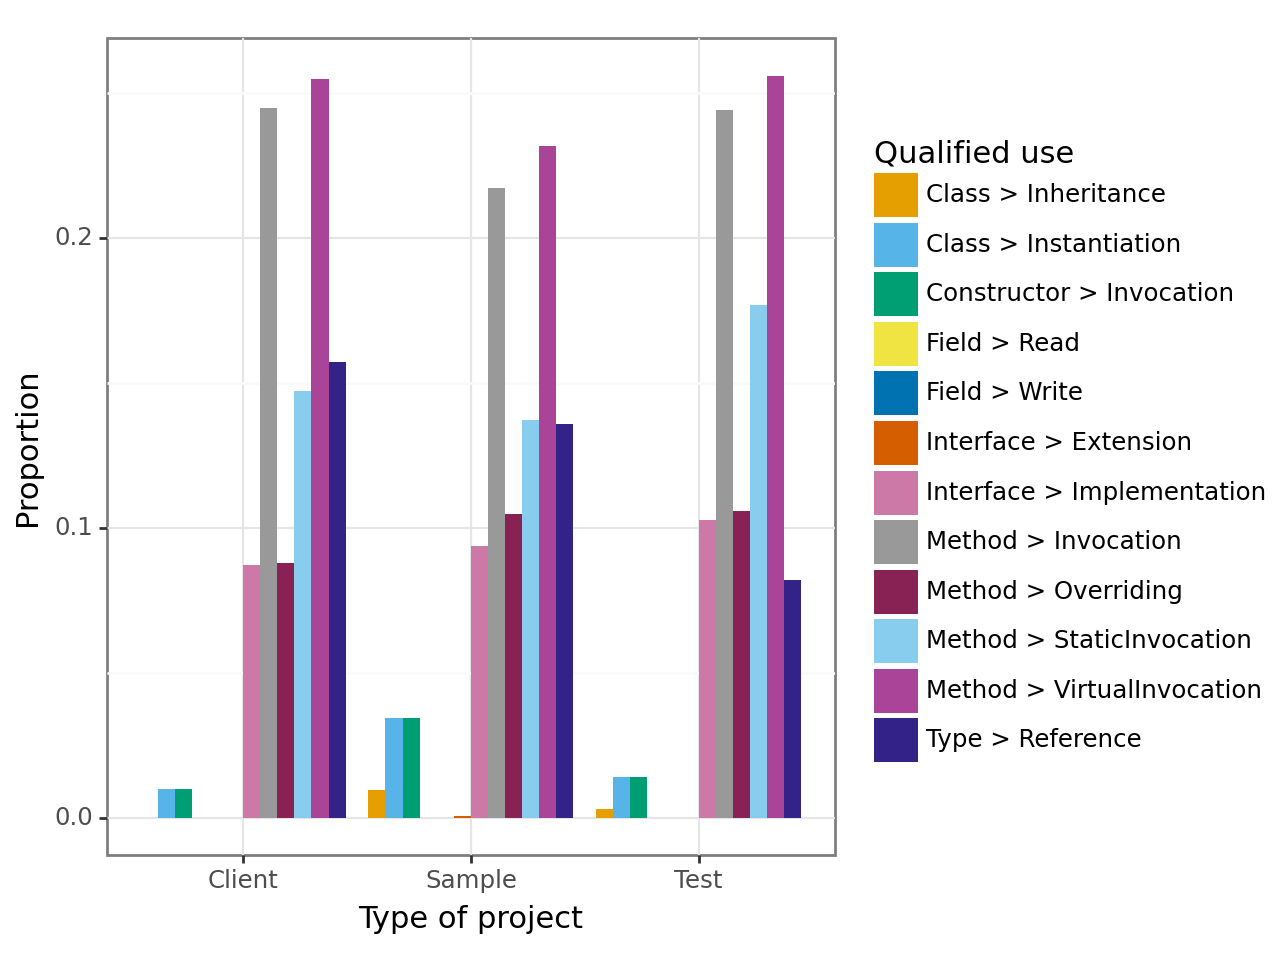

<Figure Size: (640 x 480)>

In [27]:
p = ggplot(profiles_sp_suf_by_type, aes(x="Type of project")) + geom_bar(aes(y="Proportion", fill="Qualified use"), stat="identity", position="dodge") + scale_fill_manual(values=color_blind_friendly_palette)
sanity_check_data(profiles_sp_suf_by_type, filter_column="Type of project", filter_column_value="Test", value_of_interest="Proportion")
sanity_check_data(profiles_sp_suf_by_type, filter_column="Type of project", filter_column_value="Sample", value_of_interest="Proportion")
sanity_check_data(profiles_sp_suf_by_type, filter_column="Type of project", filter_column_value="Client", value_of_interest="Proportion")
p.save("spark-suf-type-profiles.pdf")
p

## Analysis of the intersections between client/sample/test at the symbol level

/tmp/ipykernel_4313/2765140486.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


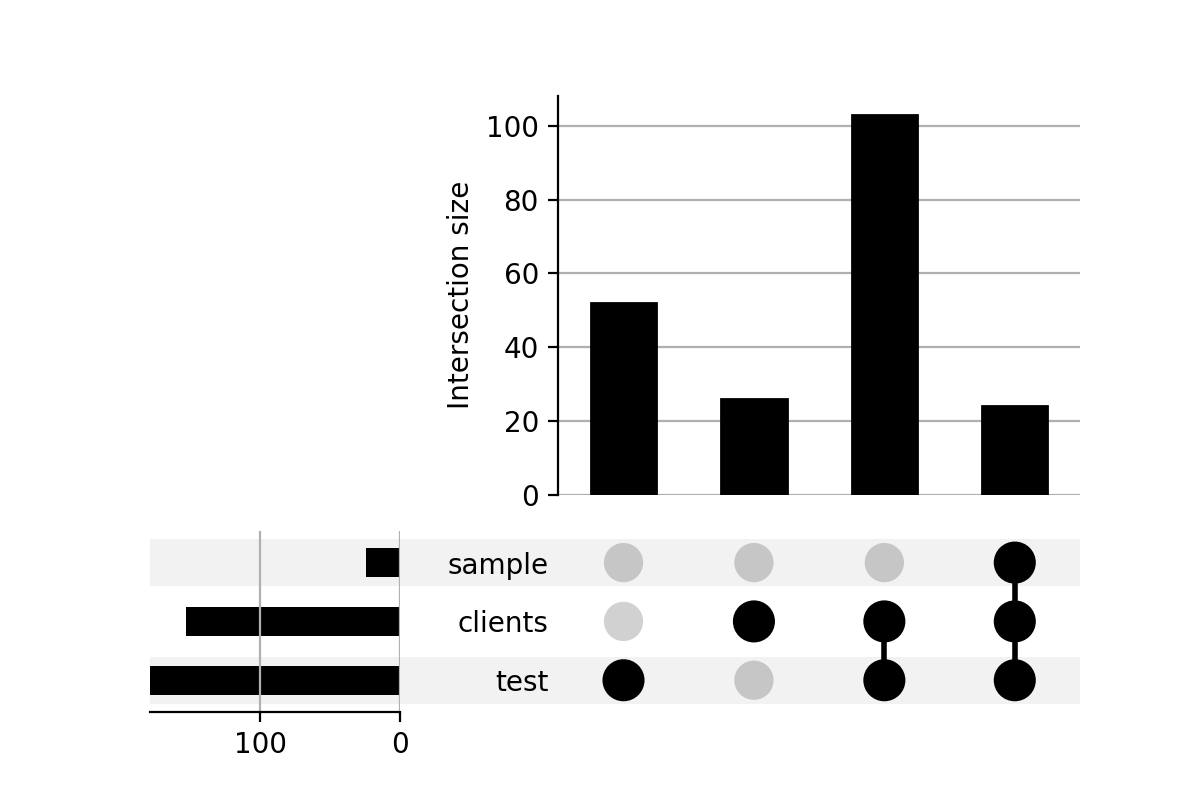

In [28]:
cc_all_symbols = cc_suf[["Type of project", "usageFullyQualifiedName"]]
#cc_all_uses["qualifiedUse"] = cc_all_uses["usageFullyQualifiedName"] + " > " + cc_all_uses["usageType"]
#cc_all_uses = cc_all_uses[["Type of project", "qualifiedUse"]]

cc_all_symbols.drop_duplicates(inplace=True)

contents = {
    "test": cc_all_symbols[cc_all_symbols["Type of project"] == "Test"]["usageFullyQualifiedName"].to_list(),
    "sample": cc_all_symbols[cc_all_symbols["Type of project"] == "Sample"]["usageFullyQualifiedName"].to_list(),
    "clients": cc_all_symbols[cc_all_symbols["Type of project"] == "Client"]["usageFullyQualifiedName"].to_list(),
}

fig = mp.pyplot.figure(figsize=(6, 4))
usp.plot(usp.from_contents(contents), fig=fig, element_size=None)
mp.pyplot.savefig("commons-cli-upset-all-symbols.pdf")
mp.pyplot.show()

## Analysis of the intersections between client/sample/test at the uses level

/tmp/ipykernel_4313/374523910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


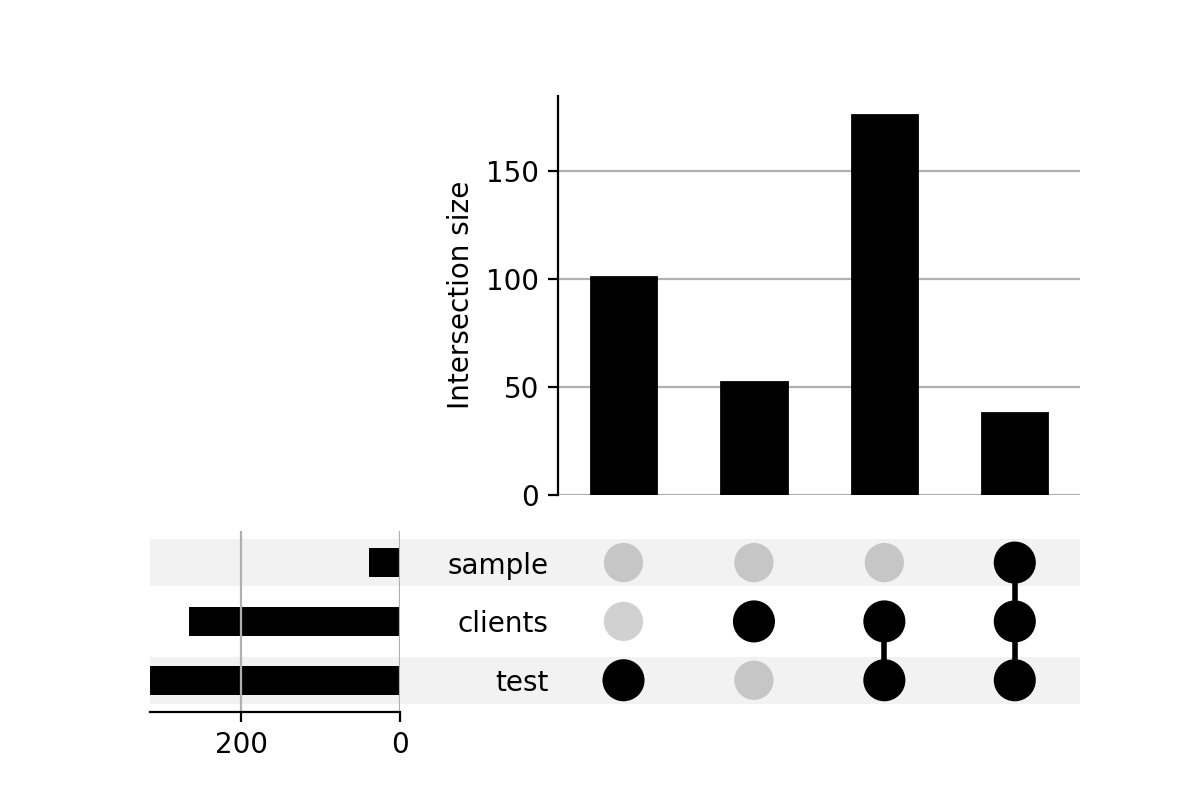

In [29]:
cc_all_uses = cc_suf[["Type of project", "usageFullyQualifiedName", "usageType"]]
cc_all_uses["qualifiedUse"] = cc_all_uses["usageFullyQualifiedName"] + " > " + cc_all_uses["usageType"]
cc_all_uses = cc_all_uses[["Type of project", "qualifiedUse"]]
cc_all_uses.drop_duplicates(inplace=True)
contents = {
    "test": cc_all_uses[cc_all_uses["Type of project"] == "Test"]["qualifiedUse"].to_list(),
    "sample": cc_all_uses[cc_all_uses["Type of project"] == "Sample"]["qualifiedUse"].to_list(),
    "clients": cc_all_uses[cc_all_uses["Type of project"] == "Client"]["qualifiedUse"].to_list(),
}

fig = mp.pyplot.figure(figsize=(6, 4))
usp.plot(usp.from_contents(contents), fig=fig, element_size=None)
mp.pyplot.savefig("commons-cli-upset-all-uses.pdf")
mp.pyplot.show()  

In [30]:
commonscli_sample_uses = cc_all_uses[cc_all_uses["Type of project"] == "Sample"]
commonscli_client_uses = cc_all_uses[cc_all_uses["Type of project"] == "Client"]
commonscli_test_uses = cc_all_uses[cc_all_uses["Type of project"] == "Test"]

commonscli_test_client_uses = pd.merge(commonscli_test_uses, commonscli_client_uses, how='inner', on=['qualifiedUse'])["qualifiedUse"].to_list()

commonscli_sample_uses_list = commonscli_sample_uses["qualifiedUse"].to_list()
commonscli_test_uses_list = commonscli_test_uses["qualifiedUse"].to_list()
commonscli_client_uses_list = commonscli_client_uses["qualifiedUse"].to_list()

for item in commonscli_sample_uses_list:
    if item in commonscli_test_client_uses:
        try:
            commonscli_test_client_uses.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

for item in commonscli_test_uses_list:
    if item in commonscli_client_uses_list:
        try:
            commonscli_client_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

print("Uses contributed by tests and clients but not samples for commons-cli")
display(commonscli_test_client_uses)

print("Uses contributed by clients only for commons-cli")
display(commonscli_client_uses_list)

Uses contributed by tests and clients but not samples for commons-cli


['org.apache.commons.cli.OptionBuilder.hasArg(boolean) > StaticInvocation',
 'org.apache.commons.cli.OptionBuilder.withDescription(java.lang.String) > StaticInvocation',
 'org.apache.commons.cli.OptionBuilder.withLongOpt(java.lang.String) > StaticInvocation',
 'org.apache.commons.cli.OptionBuilder.create(char) > StaticInvocation',
 'org.apache.commons.cli.OptionBuilder.withArgName(java.lang.String) > StaticInvocation',
 'org.apache.commons.cli.OptionBuilder.hasArg() > StaticInvocation',
 'org.apache.commons.cli.OptionBuilder.hasOptionalArg() > StaticInvocation',
 'org.apache.commons.cli.Parser > Reference',
 'org.apache.commons.cli.PosixParser() > Invocation',
 'org.apache.commons.cli.PosixParser > Instantiation',
 'org.apache.commons.cli.PosixParser > Reference',
 'org.apache.commons.cli.CommandLineParser.parse(org.apache.commons.cli.Options,java.lang.String[],boolean) > VirtualInvocation',
 'org.apache.commons.cli.Parser.parse(org.apache.commons.cli.Options,java.lang.String[],boolean

Uses contributed by clients only for commons-cli


['org.apache.commons.cli.ParseException(java.lang.String) > Invocation',
 'org.apache.commons.cli.ParseException > Instantiation',
 'org.apache.commons.cli.DefaultParser.parse(org.apache.commons.cli.Options,java.lang.String[],boolean) > Invocation',
 'org.apache.commons.cli.OptionBuilder.isRequired(boolean) > StaticInvocation',
 'org.apache.commons.cli.Option.setValueSeparator(char) > Invocation',
 'org.apache.commons.cli.Options.addRequiredOption(java.lang.String,java.lang.String,boolean,java.lang.String) > Invocation',
 'org.apache.commons.cli.HelpFormatter.printHelp(java.lang.String,org.apache.commons.cli.Options,boolean) > Invocation',
 'org.apache.commons.cli.DefaultParser.parse(org.apache.commons.cli.Options,java.lang.String[],java.util.Properties,boolean) > Invocation',
 'org.apache.commons.cli.HelpFormatter.printHelp(java.lang.String,java.lang.String,org.apache.commons.cli.Options,java.lang.String,boolean) > Invocation',
 'org.apache.commons.cli.GnuParser > Inheritance',
 'org.

/tmp/ipykernel_4313/3807419787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


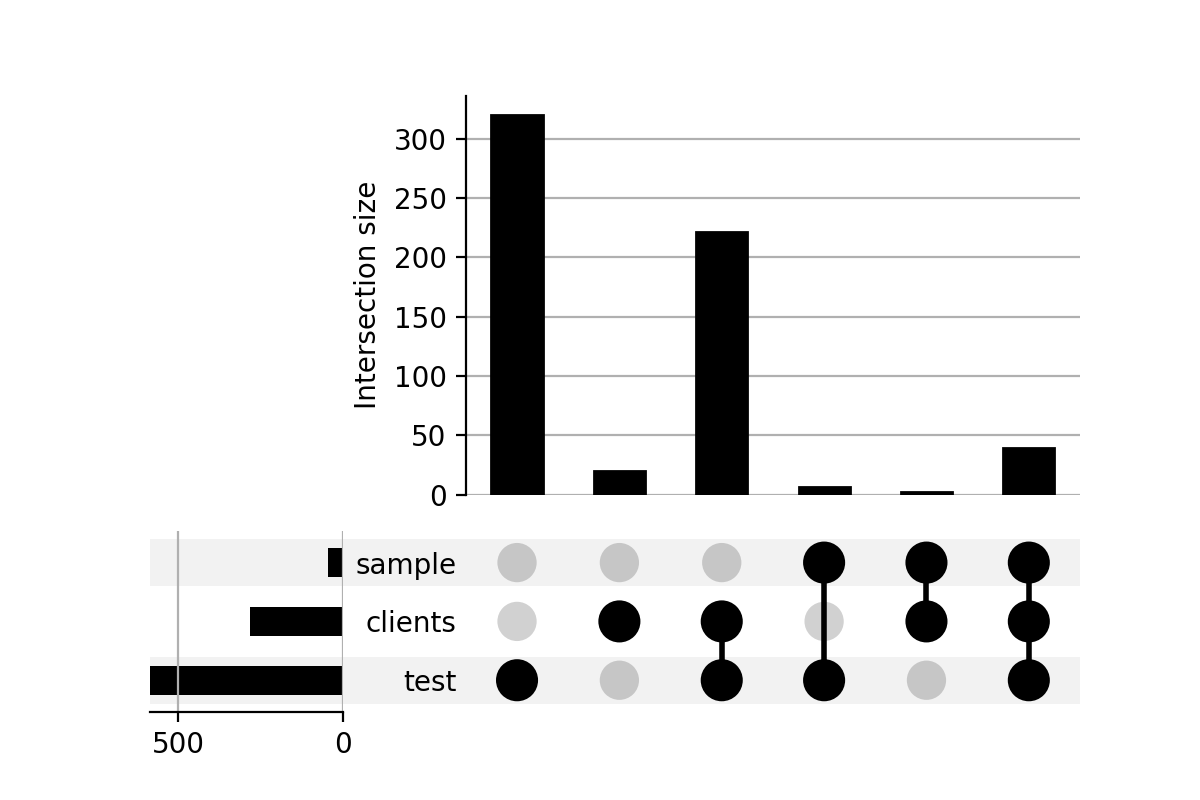

In [31]:
js_all_symbols = js_suf[["Type of project", "usageFullyQualifiedName"]]
js_all_symbols.drop_duplicates(inplace=True)

contents = {
    "test": js_all_symbols[js_all_symbols["Type of project"] == "Test"]["usageFullyQualifiedName"].to_list(),
    "sample": js_all_symbols[js_all_symbols["Type of project"] == "Sample"]["usageFullyQualifiedName"].to_list(),
    "clients": js_all_symbols[js_all_symbols["Type of project"] == "Client"]["usageFullyQualifiedName"].to_list(),
}

fig = mp.pyplot.figure(figsize=(6, 4))
usp.plot(usp.from_contents(contents), fig=fig, element_size=None)
mp.pyplot.savefig("jsoup-upset-all-symbols.pdf")
mp.pyplot.show()

/tmp/ipykernel_4313/954435376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


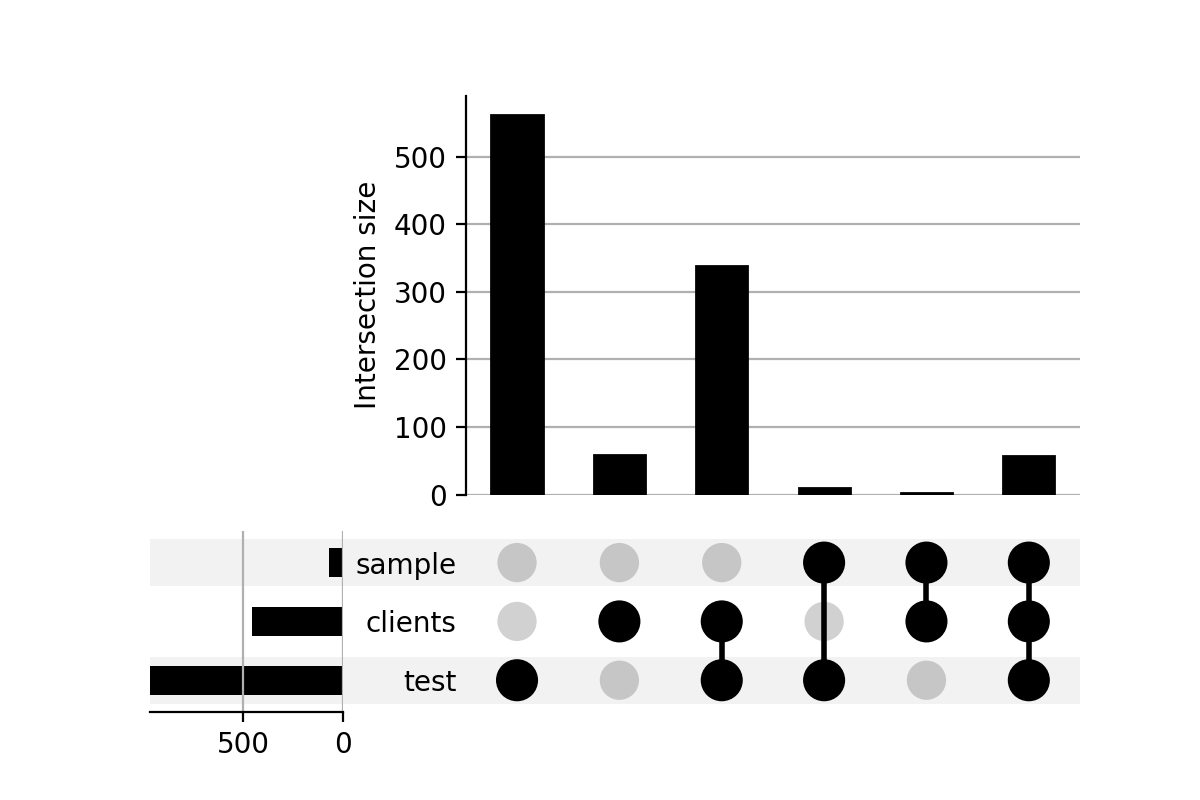

In [32]:
js_all_uses = js_suf[["Type of project", "usageFullyQualifiedName", "usageType"]]
js_all_uses["qualifiedUse"] = js_all_uses["usageFullyQualifiedName"] + " > " + js_all_uses["usageType"]
js_all_uses = js_all_uses[["Type of project", "qualifiedUse"]]
js_all_uses.drop_duplicates(inplace=True)
contents = {
    "test": js_all_uses[js_all_uses["Type of project"] == "Test"]["qualifiedUse"].to_list(),
    "sample": js_all_uses[js_all_uses["Type of project"] == "Sample"]["qualifiedUse"].to_list(),
    "clients": js_all_uses[js_all_uses["Type of project"] == "Client"]["qualifiedUse"].to_list(),
}

fig = mp.pyplot.figure(figsize=(6, 4))
usp.plot(usp.from_contents(contents), fig=fig, element_size=None)
mp.pyplot.savefig("jsoup-upset-all-uses.pdf")
mp.pyplot.show()  

In [33]:
jsoup_sample_uses = js_all_uses[js_all_uses["Type of project"] == "Sample"]
jsoup_client_uses = js_all_uses[js_all_uses["Type of project"] == "Client"]
jsoup_test_uses = js_all_uses[js_all_uses["Type of project"] == "Test"]

jsoup_sample_client_uses = pd.merge(jsoup_sample_uses, jsoup_client_uses, how='inner', on=['qualifiedUse'])["qualifiedUse"].to_list()
jsoup_test_client_uses = pd.merge(jsoup_test_uses, jsoup_client_uses, how='inner', on=['qualifiedUse'])["qualifiedUse"].to_list()

jsoup_test_uses_list = jsoup_test_uses["qualifiedUse"].to_list()
jsoup_sample_uses_list = jsoup_sample_uses["qualifiedUse"].to_list()
jsoup_client_uses_list = jsoup_client_uses["qualifiedUse"].to_list()

for item in jsoup_test_uses_list:
    if item in jsoup_sample_client_uses:
        try:
            jsoup_sample_client_uses.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')


for item in jsoup_sample_uses_list:
    if item in jsoup_test_client_uses:
        try:
            jsoup_test_client_uses.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')


for item in jsoup_sample_uses_list:
    if item in jsoup_client_uses_list:
        try:
            jsoup_client_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

for item in jsoup_test_uses_list:
    if item in jsoup_client_uses_list:
        try:
            jsoup_client_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

print("Uses contributed by tests and clients but not samples for JSoup")
display(jsoup_test_client_uses)

print("Uses exclusive to clients and not in samples or tests")
display(jsoup_client_uses_list)

print("Uses contributed by samples and clients but not tests for JSoup")
display(jsoup_sample_client_uses)

Uses contributed by tests and clients but not samples for JSoup


['org.jsoup.nodes.Node.toString() > Invocation',
 'org.jsoup.parser.Parser.htmlParser() > StaticInvocation',
 'org.jsoup.nodes.Document.outerHtml() > Invocation',
 'org.jsoup.nodes.Document.head() > Invocation',
 'org.jsoup.select.Elements.text() > Invocation',
 'org.jsoup.Jsoup.parse(java.io.InputStream,java.lang.String,java.lang.String) > StaticInvocation',
 'org.jsoup.Jsoup.parse(java.io.File,java.lang.String) > StaticInvocation',
 'org.jsoup.nodes.Element.selectFirst(java.lang.String) > Invocation',
 'org.jsoup.Jsoup.parse(java.lang.String,java.lang.String) > StaticInvocation',
 'org.jsoup.helper.DataUtil.readToByteBuffer(java.io.InputStream,int) > StaticInvocation',
 'org.jsoup.nodes.Document.outputSettings() > Invocation',
 'org.jsoup.Connection > Reference',
 'org.jsoup.Connection$Base.cookies() > VirtualInvocation',
 'org.jsoup.Connection$Base.url() > VirtualInvocation',
 'org.jsoup.Connection.referrer(java.lang.String) > VirtualInvocation',
 'org.jsoup.Connection.method(org.js

Uses exclusive to clients and not in samples or tests


['org.jsoup.nodes.Node.equals(java.lang.Object) > Invocation',
 'org.jsoup.Connection.data(java.util.Map) > VirtualInvocation',
 'org.jsoup.Connection$Base.headers() > VirtualInvocation',
 'org.jsoup.nodes.Element.getElementsMatchingOwnText(java.util.regex.Pattern) > Invocation',
 'org.jsoup.Connection$Base.header(java.lang.String,java.lang.String) > Overriding',
 'org.jsoup.Connection$Base.addHeader(java.lang.String,java.lang.String) > Overriding',
 'org.jsoup.Connection$Base.hasHeader(java.lang.String) > Overriding',
 'org.jsoup.Connection$Base.hasHeaderWithValue(java.lang.String,java.lang.String) > Overriding',
 'org.jsoup.Connection$Base.removeHeader(java.lang.String) > Overriding',
 'org.jsoup.Connection$Base.headers() > Overriding',
 'org.jsoup.Connection$Base.multiHeaders() > Overriding',
 'org.jsoup.Connection$Base.cookie(java.lang.String) > Overriding',
 'org.jsoup.Connection$Response > Implementation',
 'org.jsoup.Connection$Base.cookie(java.lang.String,java.lang.String) > Ov

Uses contributed by samples and clients but not tests for JSoup


['org.jsoup.internal.StringUtil.in(java.lang.String,java.lang.String[]) > StaticInvocation',
 'org.jsoup.helper.Validate.isTrue(boolean,java.lang.String) > StaticInvocation']

/tmp/ipykernel_4313/3799713708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


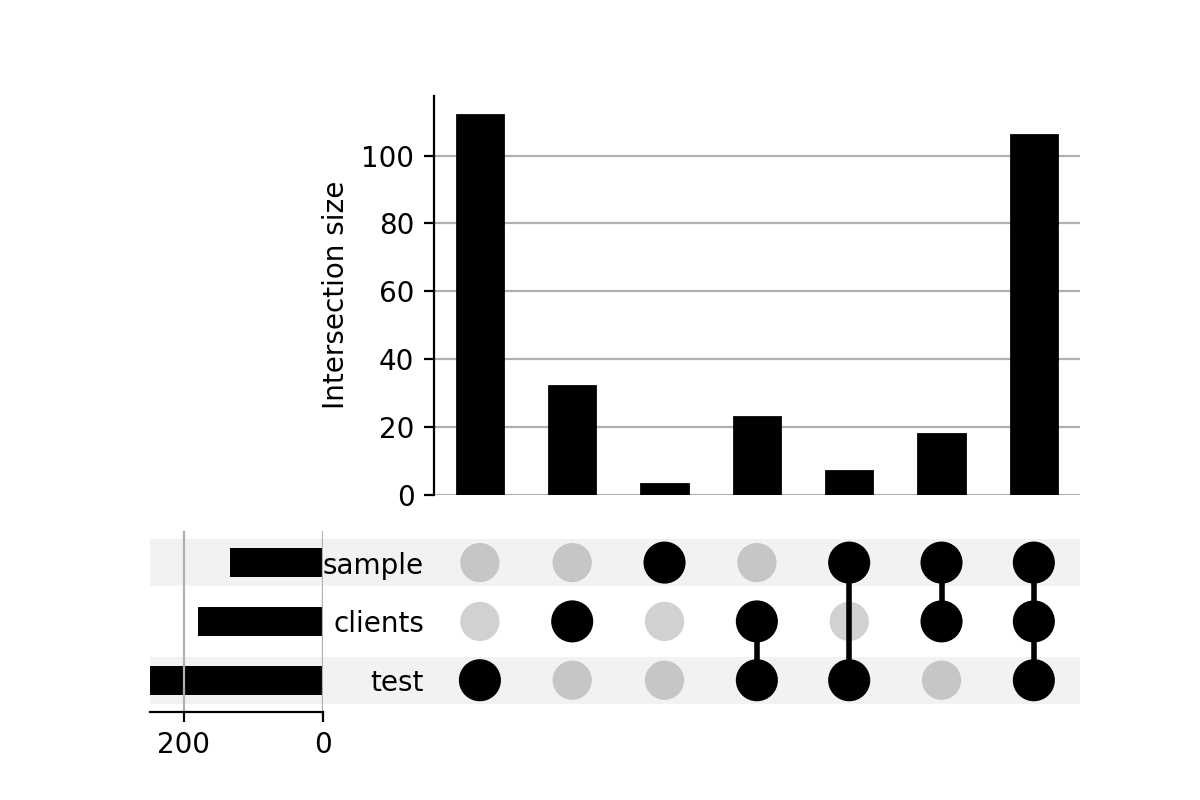

In [34]:
sp_all_symbols = sp_suf[["Type of project", "usageFullyQualifiedName"]]
sp_all_symbols.drop_duplicates(inplace=True)

contents = {
    "test": sp_all_symbols[sp_all_symbols["Type of project"] == "Test"]["usageFullyQualifiedName"].to_list(),
    "sample": sp_all_symbols[sp_all_symbols["Type of project"] == "Sample"]["usageFullyQualifiedName"].to_list(),
    "clients": sp_all_symbols[sp_all_symbols["Type of project"] == "Client"]["usageFullyQualifiedName"].to_list(),
}

fig = mp.pyplot.figure(figsize=(6, 4))
usp.plot(usp.from_contents(contents), fig=fig, element_size=None)
mp.pyplot.savefig("spark-upset-all-symbols.pdf")
mp.pyplot.show()

/tmp/ipykernel_4313/2777642875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


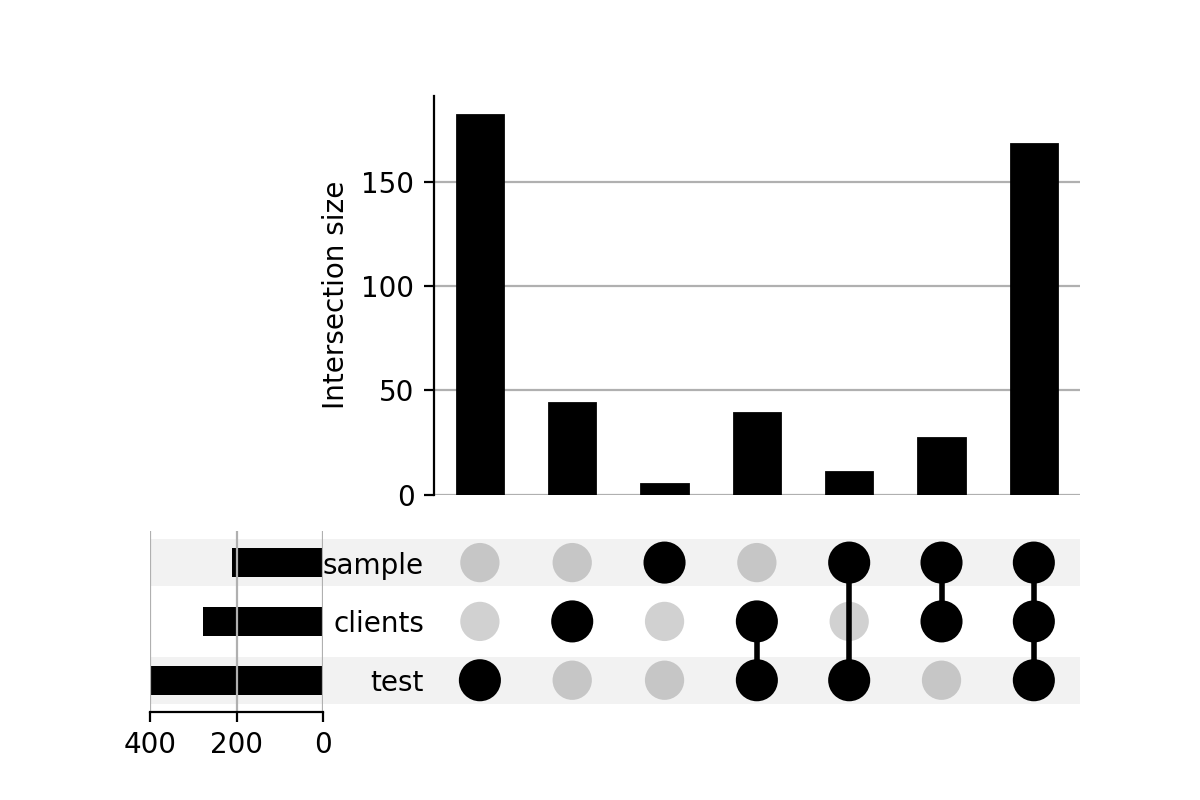

In [35]:
sp_all_uses = sp_suf[["Type of project", "usageFullyQualifiedName", "usageType"]]
sp_all_uses["qualifiedUse"] = sp_all_uses["usageFullyQualifiedName"] + " > " + sp_all_uses["usageType"]
sp_all_uses = sp_all_uses[["Type of project", "qualifiedUse"]]
sp_all_uses.drop_duplicates(inplace=True)
contents = {
    "test": sp_all_uses[sp_all_uses["Type of project"] == "Test"]["qualifiedUse"].to_list(),
    "sample": sp_all_uses[sp_all_uses["Type of project"] == "Sample"]["qualifiedUse"].to_list(),
    "clients": sp_all_uses[sp_all_uses["Type of project"] == "Client"]["qualifiedUse"].to_list(),
}

fig = mp.pyplot.figure(figsize=(6, 4))
usp.plot(usp.from_contents(contents), fig=fig, element_size=None)
mp.pyplot.savefig("spark-upset-all-uses.pdf")
mp.pyplot.show()

In [36]:
spark_sample_uses = sp_all_uses[sp_all_uses["Type of project"] == "Sample"]
spark_client_uses = sp_all_uses[sp_all_uses["Type of project"] == "Client"]
spark_test_uses = sp_all_uses[sp_all_uses["Type of project"] == "Test"]

spark_sample_client_uses = pd.merge(spark_sample_uses, spark_client_uses, how='inner', on=['qualifiedUse'])["qualifiedUse"].to_list()
spark_sample_test_uses = pd.merge(spark_sample_uses, spark_test_uses, how='inner', on=['qualifiedUse'])["qualifiedUse"].to_list()
spark_test_client_uses = pd.merge(spark_test_uses, spark_client_uses, how='inner', on=['qualifiedUse'])["qualifiedUse"].to_list()

spark_test_uses_list = spark_test_uses["qualifiedUse"].to_list()
spark_client_uses_list = spark_client_uses["qualifiedUse"].to_list()
spark_sample_uses_list = spark_sample_uses["qualifiedUse"].to_list()

for item in spark_test_uses_list:
    if item in spark_sample_client_uses:
        try:
            spark_sample_client_uses.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

for item in spark_client_uses_list:
    if item in spark_sample_test_uses:
        try:
            spark_sample_test_uses.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

for item in spark_sample_uses_list:
    if item in spark_test_client_uses:
        try:
            spark_test_client_uses.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

print("Uses contributed by tests and clients but not samples for Spark")
display(spark_test_client_uses)

print("Uses contributed by samples and tests but not clients for Spark")
display(spark_sample_test_uses)

print("Uses contributed by samples and clients but not tests for Spark")
display(spark_sample_client_uses)

spark_test_uses_list = spark_test_uses["qualifiedUse"].to_list()
spark_client_uses_list = spark_client_uses["qualifiedUse"].to_list()
spark_sample_uses_list = spark_sample_uses["qualifiedUse"].to_list()

for item in spark_test_uses_list:
    if item in spark_sample_uses_list:
        try:
            spark_sample_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')
            

for item in spark_client_uses_list:
    if item in spark_sample_uses_list:
        try:
            spark_sample_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

print("Uses exclusive to samples and not in clients or tests")
display(spark_sample_uses_list)

spark_test_uses_list = spark_test_uses["qualifiedUse"].to_list()
spark_client_uses_list = spark_client_uses["qualifiedUse"].to_list()
spark_sample_uses_list = spark_sample_uses["qualifiedUse"].to_list()

for item in spark_test_uses_list:
    if item in spark_client_uses_list:
        try:
            spark_client_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')
            

for item in spark_sample_uses_list:
    if item in spark_client_uses_list:
        try:
            spark_client_uses_list.remove(item)
        except ValueError:
            print(f'Error removing {item} from list')

print("Uses exclusive to clients and not in samples or tests")
display(spark_client_uses_list)

Uses contributed by tests and clients but not samples for Spark


['spark.utils.IOUtils.toString(java.io.InputStream) > StaticInvocation',
 'spark.Service.ignite() > StaticInvocation',
 'spark.Service > Reference',
 'spark.Service.port(int) > Invocation',
 'spark.Spark.patch(java.lang.String,spark.Route) > StaticInvocation',
 'spark.Spark.externalStaticFileLocation(java.lang.String) > StaticInvocation',
 'spark.Service.init() > Invocation',
 'spark.Service.awaitInitialization() > Invocation',
 'spark.Service.stop() > Invocation',
 'spark.QueryParamsMap > Reference',
 'spark.QueryParamsMap.value(java.lang.String[]) > Invocation',
 'spark.Request.queryParamOrDefault(java.lang.String,java.lang.String) > Invocation',
 'spark.Response.cookie(java.lang.String,java.lang.String,int,boolean,boolean) > Invocation',
 'spark.Response.cookie(java.lang.String,java.lang.String,java.lang.String,int,boolean,boolean) > Invocation',
 'spark.Service.ipAddress(java.lang.String) > Invocation',
 'spark.Service.threadPool(int,int,int) > Invocation',
 'spark.Service.awaitSto

Uses contributed by samples and tests but not clients for Spark


['spark.Spark.modelAndView(java.lang.Object,java.lang.String) > StaticInvocation',
 'spark.Redirect.post(java.lang.String,java.lang.String,spark.Redirect$Status) > Invocation',
 'spark.Redirect.any(java.lang.String,java.lang.String,spark.Redirect$Status) > Invocation',
 'spark.Spark.unmap(java.lang.String) > StaticInvocation',
 'spark.Spark.unmap(java.lang.String,java.lang.String) > StaticInvocation',
 'spark.Response.cookie(java.lang.String,java.lang.String,int,boolean) > Invocation',
 'spark.Response.type() > Invocation',
 'spark.Redirect.post(java.lang.String,java.lang.String,spark.Redirect$Status) > VirtualInvocation',
 'spark.Redirect.any(java.lang.String,java.lang.String,spark.Redirect$Status) > VirtualInvocation',
 'spark.Response.cookie(java.lang.String,java.lang.String,int,boolean) > VirtualInvocation',
 'spark.Response.type() > VirtualInvocation']

Uses contributed by samples and clients but not tests for Spark


['spark.Route > Reference',
 'spark.Request.params() > Invocation',
 'spark.Spark.port(int) > StaticInvocation',
 'spark.Spark.delete(java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.Spark.post(java.lang.String,java.lang.String,spark.Route) > StaticInvocation',
 'spark.Spark.options(java.lang.String,spark.Route) > StaticInvocation',
 'spark.Spark.halt() > StaticInvocation',
 'spark.Spark.post(java.lang.String,spark.TemplateViewRoute,spark.TemplateEngine) > StaticInvocation',
 'spark.utils.StringUtils.isEmpty(java.lang.Object) > StaticInvocation',
 'spark.Route.handle(spark.Request,spark.Response) > VirtualInvocation',
 'spark.TemplateEngine.render(spark.ModelAndView) > VirtualInvocation',
 'spark.Route > Extension',
 'spark.Spark.get(java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.ResponseTransformer.render(java.lang.Object) > VirtualInvocation',
 'spark.Request.raw() > Invocation',
 'spark.Request.queryMap() > In

Uses exclusive to samples and not in clients or tests


['spark.Spark.put(java.lang.String,java.lang.String,spark.Route) > StaticInvocation',
 'spark.Service$StaticFiles.header(java.lang.String,java.lang.String) > Invocation',
 'spark.Request.bodyAsBytes() > Invocation',
 'spark.Service$StaticFiles.header(java.lang.String,java.lang.String) > VirtualInvocation',
 'spark.Request.bodyAsBytes() > VirtualInvocation']

Uses exclusive to clients and not in samples or tests


['spark.ExceptionHandler > Reference',
 'spark.servlet.SparkApplication.init() > VirtualInvocation',
 'spark.Spark.port() > StaticInvocation',
 'spark.Spark.setPort(int) > StaticInvocation',
 'spark.Spark.ipAddress(java.lang.String) > StaticInvocation',
 'spark.Spark.post(java.lang.String,java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.Spark.patch(java.lang.String,java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.Spark.put(java.lang.String,java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.Spark.delete(java.lang.String,java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.Spark.post(java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.Spark.put(java.lang.String,spark.Route,spark.ResponseTransformer) > StaticInvocation',
 'spark.TemplateViewRoute > Reference',
 'spark.Spark.get(java.lang.String,java.lang.String,spark.Tem